In [1]:
# import libraries needed
import networkx as nx
from sortedcontainers import SortedList, SortedSet, SortedDict
import random
import numpy as np
import math
from itertools import chain, combinations
from networkx.generators.random_graphs import erdos_renyi_graph, fast_gnp_random_graph
from networkx.algorithms.matching import max_weight_matching
from subprocess import check_output
from gurobipy.gurobipy import Model, quicksum, GRB
import matplotlib.pylab as plt
import time

In [2]:
# Create new edge and set edge weight and cost
def setEdgeData(G, edge, weight, cost):
    G.add_edge(edge[0], edge[1])
    G[edge[0]][edge[1]]['weight'] = weight
    G[edge[0]][edge[1]]['cost'] = cost

def getEdgeCost(G, edge):
    return G[edge[0]][edge[1]]['cost']

def getEdgeWeight(G, edge):
    return G[edge[0]][edge[1]]['weight']

def zerotruncatedPoisson(p):
    #source: https://web.archive.org/web/20180826164029/http://giocc.com/zero_truncated_poisson_sampling_algorithm.html
    k = 1
    t = math.e**(-p) / (1 - math.e**(-p)) * p
    s = t
    u = random.random()
    while s < u:
        k += 1
        t *= p / k
        s += t
    return k

def isMatching(edges):
    # Check if set of edges is matching
    seen = []
    for e in edges:
        if e[0] in seen:
            return False
        seen.append(e[0])
        if e[1] in seen:
            return False
        seen.append(e[1])
    return True

def powerset(iterable, maxSize):
    "Source: https://docs.python.org/3/library/itertools.html#itertools-recipes"
    "powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(maxSize+1))
def powersetAll(iterable):
    "Source: https://docs.python.org/3/library/itertools.html#itertools-recipes"
    "powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(len(s)+1))



def generateRandomGraph(n, p, Ew, Ec):
    """
    Generates random graph using the Erdös-Rényi model.
    params
    n: number of vertices
    p: probability parameter Erdös-Rényi
    Ew: zero truncated poisson weight parameter
    Ec: poisson cost parameter
    """
    graph = erdos_renyi_graph(n,p)
    for edge in graph.edges:
        weight = 0
        cost = 0
        weight = zerotruncatedPoisson(Ew)
        cost = np.random.poisson(Ec)
        setEdgeData(graph, edge, weight, cost)
    return graph
    

def computeCost(g, matching):
    # compute cost of matching
    return sum(getEdgeCost(g, e) for e in matching)
def computeWeight(g, matching):
    # compute weight of matching
    return sum(getEdgeWeight(g, e) for e in matching)
def budgetedMatchingProblemBruteforce(g, B):
    # solve BMP by bruteforce
    maximum = 0
    cost = 0
    matching = None
    for e in powerset(g.edges, len(g.nodes)//2):
        if isMatching(e):
            c = computeCost(g, e)
            m = computeWeight(g, e)
            if c <= B and m > maximum:
                maximum = m
                matching = e
                cost = c
    return cost, maximum, matching

def generateRandomRestricted(n, p, Ec):
    """
    Generates random graph using the Erdös-Rényi model.
    The weights of all edges are 1
    The costs are following a poisson parameter
    Here the 'weight' variable of each edge denotes the edge cost not edge weight
    params
    n: number of vertices
    p: probability parameter Erdös-Rényi
    Ec: poisson cost parameter
    """
    graph = fast_gnp_random_graph(n,p)
    for edge in graph.edges:
        graph[edge[0]][edge[1]]['weight'] = np.random.poisson(Ec) # Edge cost!
    return graph

def restrictedToGeneral(G):
    """
    Transform graph instance with weights 1
    to general instance of budgeted matching problem
    """
    graph = nx.Graph()
    for e in G.edges():
        setEdgeData(graph, e, 1, G[e[0]][e[1]]['weight'])
    return graph

In [3]:
### Using Min Weight Max Cardinality Matching

G = generateRandomRestricted(40,0.8,5)

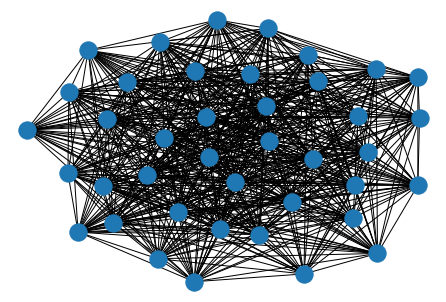

In [4]:
nx.draw(G)

In [5]:
def transform_graph(G, weight="weight"):
    """
    Transforms min weight to max weight problem
    """
    if len(G.edges) == 0:
        return max_weight_matching(G, maxcardinality, weight)
    G_edges = G.edges(data=weight, default=1)
    min_weight = min([w for _, _, w in G_edges])
    InvG = nx.Graph()
    edges = ((u, v, 1 / (1 + w - min_weight)) for u, v, w in G_edges)
    InvG.add_weighted_edges_from(edges, weight=weight)
    return InvG

def transform_graph_min_size_k(G, k, weight="weight"):
    """
    Transforms max weight matching to max weight matching on k vertices
    """
    transG = nx.Graph()
    G_edges = G.edges(data=weight, default=1)
    edges = ((u, v, w) for u, v, w in G_edges)
    transG.add_weighted_edges_from(edges, weight=weight)
    old_nodes = list(G.nodes).copy()
    for i in range(len(G.nodes), 2*len(G.nodes)-2*k):
        for j in old_nodes:
            transG.add_edge(j, i, weight=0)
    return transG

def graphToAdjacency(G):
    """
    Transform graph to adjacency list
    """
    lines = []
    lines.append(str(len(G.nodes)))
    lines.append(str(len(G.edges)))
    for e in G.edges:
        e0 = e[0]
        e1 = e[1]
        lines.append(f"{e0} {e1} {G[e0][e1]['weight']}")
    return lines

def min_cost_matching(G):
    """
    Returns minimum cost perfect matching, if exists else false
    """
    adjacency = graphToAdjacency(G)
    f = open("input.txt", "w")
    for line in adjacency:
        f.write(line)
        f.write("\n")
    f.close()
    try:
        raw_data = check_output('MinimumCostMatching\example -f input.txt --minweight', shell=True).decode('utf-8').split(":")[-1].split("\r\n")
    except:
        return False
    return set(tuple(int(e) for e in x.split(" ")) for x in raw_data if x!="")

def min_cost_matching_size_k(G, k):
    """
    Compute minimum cost matching of size k
    """
    graph = transform_graph_min_size_k(G, k)
    matching = min_cost_matching(graph)
    if matching == False: return False
    nodesG = len(G.nodes)
    return set(x for x in matching if (x[0] < nodesG and x[1] < nodesG))
    
def budgetedMatchingPolynomial(G, B):
    """
    BudgetedMatching on graph G with weights restricted to 1
    and buget B in polynomial time
    """
    matching = min_cost_matching(G)
    maximumWeight = len(G.nodes)//2
    cost = sum(G[e[0]][e[1]]["weight"] for e in matching) if matching != False else B
    
    while (cost > B or not(matching)) and maximumWeight > 0:
        maximumWeight -= 1
        matching = min_cost_matching_size_k(G, maximumWeight)
        if (matching != False): cost = sum(G[e[0]][e[1]]["weight"] for e in matching)
    return (cost, maximumWeight, matching)


In [6]:
def computeCost(g, matching):
    # Compute cost of matching
    return sum(getEdgeCost(g, e) for e in matching)
def computeWeight(g, matching):
    # Compute weight of matching
    return sum(getEdgeWeight(g, e) for e in matching)
def budgetedMatchingProblemBruteforce(g, B):
    # solve BMP by bruteforce
    maximum = 0
    cost = 0
    matching = None
    for e in powerset(g.edges):
        if len(e) <= len(g.nodes) and isMatching(e):
            c = computeCost(g, e)
            m = computeWeight(g, e)
            if c <= B and m > maximum:
                maximum = m
                matching = e
                cost = c
    return cost, maximum, matching

In [7]:
from gurobipy.gurobipy import Model, quicksum, GRB
# ============================================ GUROBI ====================================================
def restricted_graph_to_gurobi(graph, budget):
    # Transform graph with weights = 1 to gurobi instance
    model = Model("Budgeted Matching Restricted")
    x = {}
    edges = list(graph.edges)
    nodes = list(graph.nodes)
    for e in edges:
        x[e] = model.addVar(vtype=GRB.INTEGER, name=f'edge[{e}]', lb = 0, ub=1)
    model.addConstrs(
        (quicksum(x[e] for e in edges if v in e) <= 1 for v in nodes),
        name='Satisfy Matching'
    )
    model.addConstr(
        quicksum(x[e] * getEdgeWeight(graph, e) for e in edges) <= budget,
        name='Satisfy Budget'
    )
    model.setObjective(
        quicksum(x[e] for e in edges),
        sense=GRB.MAXIMIZE
    )
    return model

In [8]:
def check_model(graph, budget):
    # Check that budgeted matching done in polynomial time the same value gives as
    # Gurobi linear program
    m = restricted_graph_to_gurobi(graph, budget)
    m.optimize()
    num1 = budgetedMatchingPolynomial(graph, budget)[1]
    num2 = int(m.objVal)
    return num1 == num2

In [38]:
'''
Test of budgeted matching polynomial program on dense graphs
Results get saved in dict times_brute_dense and times_gurobi_dense
'''
# Dense Graphs
times_brute_dense = {}
times_gurobi_dense = {}
for n in range(2,101):
    print("iterationnumber", n)
    running_time_bruteforce = 0
    running_time_gurobi = 0
    for i in range(5):
        g = generateRandomRestricted(n, 0.8, 10)
        gurobi = restricted_graph_to_gurobi(g, 3*n)
        start = time.time()
        budgetedMatchingPolynomial(g, 3*n)
        end = time.time()
        running_time_bruteforce += end - start
        
        start = time.time()
        gurobi.optimize()
        end = time.time()
        running_time_gurobi += end - start
    times_brute_dense[n] = running_time_bruteforce / 5
    times_gurobi_dense[n] = running_time_gurobi / 5

iterationnumber 2
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 3 rows, 1 columns and 3 nonzeros
Model fingerprint: 0xa57b1f3f
Variable types: 0 continuous, 1 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 7e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 6e+00]
Found heuristic solution: objective -0.0000000
Presolve removed 3 rows and 1 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.01 seconds
Thread count was 1 (of 12 available processors)

Solution count 1: -0 
No other solutions better than -0

Optimal solution found (tolerance 1.00e-04)
Best objective -0.000000000000e+00, best bound -0.000000000000e+00, gap 0.0000%
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to


Solution count 1: 1 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.000000000000e+00, best bound 1.000000000000e+00, gap 0.0000%
iterationnumber 4
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 5 rows, 6 columns and 18 nonzeros
Model fingerprint: 0x96b7a0c6
Variable types: 0 continuous, 6 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+01]
Found heuristic solution: objective 1.0000000
Presolve removed 5 rows and 6 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.01 seconds
Thread count was 1 (of 12 available processors)

Solution count 1: 1 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.000000000000e+00, best bound 1.000000000000e+00, gap 0.0000%
Gurobi Optimi

Thread count was 1 (of 12 available processors)

Solution count 2: 2 1 

Optimal solution found (tolerance 1.00e-04)
Best objective 2.000000000000e+00, best bound 2.000000000000e+00, gap 0.0000%
iterationnumber 6
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 7 rows, 12 columns and 36 nonzeros
Model fingerprint: 0x9bd1ad26
Variable types: 0 continuous, 12 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+01]
Found heuristic solution: objective 1.0000000
Presolve removed 1 rows and 4 columns
Presolve time: 0.00s
Presolved: 6 rows, 8 columns, 23 nonzeros
Found heuristic solution: objective 2.0000000
Variable types: 0 continuous, 8 integer (8 binary)

Root relaxation: cutoff, 1 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds 

Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 8 rows, 18 columns and 54 nonzeros
Model fingerprint: 0x86c7aee6
Variable types: 0 continuous, 18 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+01]
Found heuristic solution: objective 2.0000000
Presolve removed 0 rows and 2 columns
Presolve time: 0.00s
Presolved: 8 rows, 16 columns, 48 nonzeros
Found heuristic solution: objective 3.0000000
Variable types: 0 continuous, 16 integer (16 binary)

Root relaxation: cutoff, 1 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0     cutoff    0         3.00000    3.00000  0.00%     -    0s

Explored 0 nodes (1 simplex iterations) 

Variable types: 0 continuous, 23 integer (23 binary)

Root relaxation: cutoff, 10 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0     cutoff    0         3.00000    3.00000  0.00%     -    0s

Explored 0 nodes (10 simplex iterations) in 0.01 seconds
Thread count was 12 (of 12 available processors)

Solution count 1: 3 

Optimal solution found (tolerance 1.00e-04)
Best objective 3.000000000000e+00, best bound 3.000000000000e+00, gap 0.0000%
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 9 rows, 20 columns and 60 nonzeros
Model fingerprint: 0x587ff979
Variable types: 0 continuous, 20 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range     

Found heuristic solution: objective 3.0000000
Presolve time: 0.00s
Presolved: 11 rows, 39 columns, 117 nonzeros
Variable types: 0 continuous, 39 integer (39 binary)

Root relaxation: objective 5.000000e+00, 13 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0       5.0000000    5.00000  0.00%     -    0s

Explored 0 nodes (13 simplex iterations) in 0.01 seconds
Thread count was 12 (of 12 available processors)

Solution count 2: 5 3 

Optimal solution found (tolerance 1.00e-04)
Best objective 5.000000000000e+00, best bound 5.000000000000e+00, gap 0.0000%
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 11 rows, 35 columns and 105 nonzeros
Model fingerprint: 0xacac0729
Variable types: 0 continuous, 35 integer (0 binary)
Coefficien

Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 12 rows, 44 columns and 132 nonzeros
Model fingerprint: 0x2489c67d
Variable types: 0 continuous, 44 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 3e+01]
Found heuristic solution: objective 3.0000000
Presolve time: 0.00s
Presolved: 12 rows, 44 columns, 132 nonzeros
Variable types: 0 continuous, 44 integer (44 binary)

Root relaxation: objective 4.700000e+00, 21 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    4.70000    0    1    3.00000    4.70000  56.7%     -    0s
H    0     0                       4.0000000    4.70000  17.5%     -    0s
     0     0    4.70000    0 

 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    6.00000    0    9    3.00000    6.00000   100%     -    0s
H    0     0                       6.0000000    6.00000  0.00%     -    0s
     0     0    6.00000    0    9    6.00000    6.00000  0.00%     -    0s

Explored 1 nodes (19 simplex iterations) in 0.01 seconds
Thread count was 12 (of 12 available processors)

Solution count 2: 6 3 

Optimal solution found (tolerance 1.00e-04)
Best objective 6.000000000000e+00, best bound 6.000000000000e+00, gap 0.0000%
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 13 rows, 51 columns and 153 nonzeros
Model fingerprint: 0x1ed8eb3b
Variable types: 0 continuous, 51 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 4e+01]
Found heu


Solution count 2: 6 5 

Optimal solution found (tolerance 1.00e-04)
Best objective 6.000000000000e+00, best bound 6.000000000000e+00, gap 0.0000%
iterationnumber 14
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 15 rows, 79 columns and 237 nonzeros
Model fingerprint: 0x351c9a2b
Variable types: 0 continuous, 79 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 4e+01]
Found heuristic solution: objective 4.0000000
Presolve time: 0.00s
Presolved: 15 rows, 79 columns, 237 nonzeros
Variable types: 0 continuous, 79 integer (79 binary)

Root relaxation: objective 6.950000e+00, 38 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 

  Matrix range     [1e+00, 2e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+01]
Found heuristic solution: objective 4.0000000
Presolve time: 0.00s
Presolved: 16 rows, 88 columns, 264 nonzeros
Variable types: 0 continuous, 88 integer (88 binary)

Root relaxation: objective 7.400000e+00, 33 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    7.40000    0    5    4.00000    7.40000  85.0%     -    0s
H    0     0                       7.0000000    7.40000  5.71%     -    0s
     0     0    7.40000    0    5    7.00000    7.40000  5.71%     -    0s

Explored 1 nodes (33 simplex iterations) in 0.01 seconds
Thread count was 12 (of 12 available processors)

Solution count 2: 7 4 

Optimal solution found (tolerance 1.00e-04)
Best objective 7.000000000000e+00, best bound 7.000000000000e+00, gap 0.0000


    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

H    0     0                       8.0000000   98.00000  1125%     -    0s
     0     0          -    0         8.00000    8.00000  0.00%     -    0s

Explored 0 nodes (35 simplex iterations) in 0.01 seconds
Thread count was 12 (of 12 available processors)

Solution count 2: 8 4 

Optimal solution found (tolerance 1.00e-04)
Best objective 8.000000000000e+00, best bound 8.000000000000e+00, gap 0.0000%
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 17 rows, 96 columns and 288 nonzeros
Model fingerprint: 0xf666a654
Variable types: 0 continuous, 96 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+01]
Found heur

Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 18 rows, 109 columns and 327 nonzeros
Model fingerprint: 0xaf829943
Variable types: 0 continuous, 109 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+01]
Found heuristic solution: objective 5.0000000
Presolve time: 0.00s
Presolved: 18 rows, 109 columns, 327 nonzeros
Variable types: 0 continuous, 109 integer (109 binary)

Root relaxation: objective 8.500000e+00, 28 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    8.50000    0    8    5.00000    8.50000  70.0%     -    0s
H    0     0                       8.0000000    8.50000  6.25%     -    0s
     0     0    8.50000    0    8    8.00000    8.50000  6.25%     -    0s

Exp

Root relaxation: objective 9.300000e+00, 80 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    9.30000    0    5    6.00000    9.30000  55.0%     -    0s
H    0     0                       9.0000000    9.30000  3.33%     -    0s
     0     0    9.30000    0    5    9.00000    9.30000  3.33%     -    0s

Explored 1 nodes (80 simplex iterations) in 0.01 seconds
Thread count was 12 (of 12 available processors)

Solution count 2: 9 6 

Optimal solution found (tolerance 1.00e-04)
Best objective 9.000000000000e+00, best bound 9.000000000000e+00, gap 0.0000%
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 20 rows, 136 columns and 408 nonzeros
Model fingerprint: 0x8cf825d6
Variable types: 0 continuous, 136 integer (0 binary)
Coefficient statistics:



Explored 0 nodes (127 simplex iterations) in 0.01 seconds
Thread count was 12 (of 12 available processors)

Solution count 2: 10 5 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.000000000000e+01, best bound 1.000000000000e+01, gap 0.0000%
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 21 rows, 152 columns and 456 nonzeros
Model fingerprint: 0x47889e25
Variable types: 0 continuous, 152 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 6e+01]
Found heuristic solution: objective 7.0000000
Presolve time: 0.00s
Presolved: 21 rows, 152 columns, 456 nonzeros
Variable types: 0 continuous, 152 integer (152 binary)

Root relaxation: objective 1.000000e+01, 33 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     W

Optimize a model with 22 rows, 167 columns and 501 nonzeros
Model fingerprint: 0x7bd44354
Variable types: 0 continuous, 167 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 6e+01]
Found heuristic solution: objective 6.0000000
Presolve time: 0.00s
Presolved: 22 rows, 167 columns, 501 nonzeros
Variable types: 0 continuous, 167 integer (167 binary)

Root relaxation: objective 1.050000e+01, 61 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   10.50000    0    3    6.00000   10.50000  75.0%     -    0s
H    0     0                      10.0000000   10.50000  5.00%     -    0s
     0     0   10.50000    0    3   10.00000   10.50000  5.00%     -    0s

Explored 1 nodes (127 simplex iterations) in 0.01 seconds
Thread count was 12 (of

 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   11.00000    0    9    8.00000   11.00000  37.5%     -    0s
H    0     0                      10.0000000   11.00000  10.0%     -    0s
H    0     0                      11.0000000   11.00000  0.00%     -    0s
     0     0   11.00000    0    9   11.00000   11.00000  0.00%     -    0s

Explored 1 nodes (52 simplex iterations) in 0.01 seconds
Thread count was 12 (of 12 available processors)

Solution count 3: 11 10 8 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.100000000000e+01, best bound 1.100000000000e+01, gap 0.0000%
iterationnumber 23
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 24 rows, 193 columns and 579 nonzeros
Model fingerprint: 0xb4d93e03
Variable types: 0 continuous, 193 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective

H    0     0                      12.0000000   12.00000  0.00%     -    0s
     0     0   12.00000    0    8   12.00000   12.00000  0.00%     -    0s

Explored 1 nodes (72 simplex iterations) in 0.01 seconds
Thread count was 12 (of 12 available processors)

Solution count 3: 12 11 9 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.200000000000e+01, best bound 1.200000000000e+01, gap 0.0000%
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 25 rows, 223 columns and 669 nonzeros
Model fingerprint: 0xa810eb87
Variable types: 0 continuous, 223 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 7e+01]
Found heuristic solution: objective 7.0000000
Presolve time: 0.00s
Presolved: 25 rows, 223 columns, 669 nonzeros
Variable types: 0 continuous, 223 integer (

  RHS range        [1e+00, 8e+01]
Found heuristic solution: objective 8.0000000
Presolve time: 0.00s
Presolved: 26 rows, 239 columns, 717 nonzeros
Variable types: 0 continuous, 239 integer (239 binary)

Root relaxation: objective 1.250000e+01, 70 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   12.50000    0    3    8.00000   12.50000  56.3%     -    0s
H    0     0                      12.0000000   12.50000  4.17%     -    0s
     0     0   12.50000    0    3   12.00000   12.50000  4.17%     -    0s

Explored 1 nodes (70 simplex iterations) in 0.02 seconds
Thread count was 12 (of 12 available processors)

Solution count 2: 12 8 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.200000000000e+01, best bound 1.200000000000e+01, gap 0.0000%
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 6 physical cores, 12 logica


    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   13.00000    0    9    7.00000   13.00000  85.7%     -    0s
H    0     0                      12.0000000   13.00000  8.33%     -    0s
H    0     0                      13.0000000   13.00000  0.00%     -    0s
     0     0   13.00000    0    9   13.00000   13.00000  0.00%     -    0s

Explored 1 nodes (72 simplex iterations) in 0.02 seconds
Thread count was 12 (of 12 available processors)

Solution count 3: 13 12 7 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.300000000000e+01, best bound 1.300000000000e+01, gap 0.0000%
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 27 rows, 255 columns and 765 nonzeros
Model fingerprint: 0x4046451e
Variable types: 0 continuous, 255 integer (0 binary)
Coefficient st


Explored 1 nodes (126 simplex iterations) in 0.01 seconds
Thread count was 12 (of 12 available processors)

Solution count 2: 13 8 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.300000000000e+01, best bound 1.300000000000e+01, gap 0.0000%
iterationnumber 28
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 29 rows, 302 columns and 906 nonzeros
Model fingerprint: 0x7d15bf7f
Variable types: 0 continuous, 302 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 8e+01]
Found heuristic solution: objective 8.0000000
Presolve time: 0.00s
Presolved: 29 rows, 302 columns, 906 nonzeros
Variable types: 0 continuous, 302 integer (302 binary)

Root relaxation: objective 1.400000e+01, 75 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective 

  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 9e+01]
Found heuristic solution: objective 11.0000000
Presolve time: 0.00s
Presolved: 30 rows, 316 columns, 948 nonzeros
Variable types: 0 continuous, 316 integer (316 binary)

Root relaxation: objective 1.450000e+01, 75 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   14.50000    0    3   11.00000   14.50000  31.8%     -    0s
H    0     0                      14.0000000   14.50000  3.57%     -    0s
     0     0   14.50000    0    3   14.00000   14.50000  3.57%     -    0s

Explored 1 nodes (257 simplex iterations) in 0.02 seconds
Thread count was 12 (of 12 available processors)

Solution count 2: 14 11 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.400000000000e+01, best bound 1.400000000000e+01, gap 0.0000%
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thre

Variable types: 0 continuous, 345 integer (345 binary)

Root relaxation: objective 1.500000e+01, 89 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   15.00000    0    4   10.00000   15.00000  50.0%     -    0s
H    0     0                      15.0000000   15.00000  0.00%     -    0s
     0     0   15.00000    0    4   15.00000   15.00000  0.00%     -    0s

Explored 1 nodes (89 simplex iterations) in 0.01 seconds
Thread count was 12 (of 12 available processors)

Solution count 2: 15 10 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.500000000000e+01, best bound 1.500000000000e+01, gap 0.0000%
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 31 rows, 348 columns and 1044 nonzeros
Model fingerprint: 0x9a82659a
Variable types: 0 

H    0     0                      15.0000000   15.50000  3.33%     -    0s
     0     0   15.50000    0    3   15.00000   15.50000  3.33%     -    0s

Explored 1 nodes (192 simplex iterations) in 0.01 seconds
Thread count was 12 (of 12 available processors)

Solution count 2: 15 10 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.500000000000e+01, best bound 1.500000000000e+01, gap 0.0000%
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 32 rows, 372 columns and 1116 nonzeros
Model fingerprint: 0x61d962bb
Variable types: 0 continuous, 372 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 9e+01]
Found heuristic solution: objective 8.0000000
Presolve time: 0.00s
Presolved: 32 rows, 372 columns, 1116 nonzeros
Variable types: 0 continuous, 372 integer 

Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 34 rows, 435 columns and 1305 nonzeros
Model fingerprint: 0x850ef0e7
Variable types: 0 continuous, 435 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+02]
Found heuristic solution: objective 12.0000000
Presolve time: 0.00s
Presolved: 34 rows, 435 columns, 1305 nonzeros
Variable types: 0 continuous, 435 integer (435 binary)

Root relaxation: objective 1.650000e+01, 70 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   16.50000    0    7   12.00000   16.50000  37.5%     -    0s
H    0     0                      16.0000000   16.50000  3.13%     -    0s
     0     0   16.50000    0    7   16.00000   16.50000  3.13%     -    0s



  Matrix range     [1e+00, 2e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+02]
Found heuristic solution: objective 11.0000000
Presolve time: 0.00s
Presolved: 35 rows, 438 columns, 1314 nonzeros
Variable types: 0 continuous, 438 integer (438 binary)

Root relaxation: objective 1.700000e+01, 93 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   17.00000    0    4   11.00000   17.00000  54.5%     -    0s
H    0     0                      17.0000000   17.00000  0.00%     -    0s
     0     0   17.00000    0    4   17.00000   17.00000  0.00%     -    0s

Explored 1 nodes (140 simplex iterations) in 0.01 seconds
Thread count was 12 (of 12 available processors)

Solution count 2: 17 11 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.700000000000e+01, best bound 1.700000000000e+01, ga


     0     0   17.50000    0    3   11.00000   17.50000  59.1%     -    0s
H    0     0                      17.0000000   17.50000  2.94%     -    0s
     0     0   17.50000    0    3   17.00000   17.50000  2.94%     -    0s

Explored 1 nodes (237 simplex iterations) in 0.02 seconds
Thread count was 12 (of 12 available processors)

Solution count 2: 17 11 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.700000000000e+01, best bound 1.700000000000e+01, gap 0.0000%
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 36 rows, 482 columns and 1446 nonzeros
Model fingerprint: 0x6a8642d0
Variable types: 0 continuous, 482 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+02]
Found heuristic solution: objective 10.0000000
Presolve time: 0.00s
Presolved: 3

Best objective 1.800000000000e+01, best bound 1.800000000000e+01, gap 0.0000%
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 37 rows, 497 columns and 1491 nonzeros
Model fingerprint: 0x7130d3f6
Variable types: 0 continuous, 497 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+02]
Found heuristic solution: objective 12.0000000
Presolve time: 0.00s
Presolved: 37 rows, 497 columns, 1491 nonzeros
Variable types: 0 continuous, 497 integer (497 binary)

Root relaxation: objective 1.800000e+01, 107 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

H    0     0                      18.0000000  497.00000  2661%     -    0s
     0     0     

Variable types: 0 continuous, 568 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+02]
Found heuristic solution: objective 11.0000000
Presolve time: 0.00s
Presolved: 39 rows, 568 columns, 1704 nonzeros
Variable types: 0 continuous, 568 integer (568 binary)

Root relaxation: objective 1.900000e+01, 120 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

H    0     0                      19.0000000  568.00000  2889%     -    0s
     0     0          -    0        19.00000   19.00000  0.00%     -    0s

Explored 0 nodes (215 simplex iterations) in 0.02 seconds
Thread count was 12 (of 12 available processors)

Solution count 2: 19 11 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.900000000000e+01, best bound 1.900000000000e+01,

  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+02]
Found heuristic solution: objective 11.0000000
Presolve time: 0.00s
Presolved: 40 rows, 590 columns, 1770 nonzeros
Variable types: 0 continuous, 590 integer (590 binary)

Root relaxation: objective 1.950000e+01, 116 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   19.50000    0    3   11.00000   19.50000  77.3%     -    0s
H    0     0                      19.0000000   19.50000  2.63%     -    0s
     0     0   19.50000    0    3   19.00000   19.50000  2.63%     -    0s

Explored 1 nodes (246 simplex iterations) in 0.02 seconds
Thread count was 12 (of 12 available processors)

Solution count 2: 19 11 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.900000000000e+01, best bound 1.900000000000e+01, gap 0.0000%
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Th

 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

H    0     0                      20.0000000  606.00000  2930%     -    0s
     0     0          -    0        20.00000   20.00000  0.00%     -    0s

Explored 0 nodes (345 simplex iterations) in 0.02 seconds
Thread count was 12 (of 12 available processors)

Solution count 2: 20 13 

Optimal solution found (tolerance 1.00e-04)
Best objective 2.000000000000e+01, best bound 2.000000000000e+01, gap 0.0000%
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 41 rows, 621 columns and 1863 nonzeros
Model fingerprint: 0xb5b1de64
Variable types: 0 continuous, 621 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+02]
Found heuristic solution: objective 12.0000000
Presolve time: 0.00s
Presolved:

Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 42 rows, 673 columns and 2019 nonzeros
Model fingerprint: 0xd091aa17
Variable types: 0 continuous, 673 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+02]
Found heuristic solution: objective 15.0000000
Presolve time: 0.01s
Presolved: 42 rows, 673 columns, 2019 nonzeros
Variable types: 0 continuous, 673 integer (673 binary)

Root relaxation: objective 2.050000e+01, 134 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   20.50000    0    3   15.00000   20.50000  36.7%     -    0s
H    0     0                      20.0000000   20.50000  2.50%     -    0s
     0     0   20.50000    0    3   20.00000   20.50000  2.50%     -    0s


Presolved: 44 rows, 727 columns, 2181 nonzeros
Variable types: 0 continuous, 727 integer (727 binary)

Root relaxation: objective 2.150000e+01, 139 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   21.50000    0    3   16.00000   21.50000  34.4%     -    0s
H    0     0                      21.0000000   21.50000  2.38%     -    0s
     0     0   21.50000    0    3   21.00000   21.50000  2.38%     -    0s

Explored 1 nodes (445 simplex iterations) in 0.03 seconds
Thread count was 12 (of 12 available processors)

Solution count 2: 21 16 

Optimal solution found (tolerance 1.00e-04)
Best objective 2.100000000000e+01, best bound 2.100000000000e+01, gap 0.0000%
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 44 rows, 720 columns and 2160 nonzeros

H    0     0                      22.0000000   22.00000  0.00%     -    0s
     0     0   22.00000    0    6   22.00000   22.00000  0.00%     -    0s

Explored 1 nodes (106 simplex iterations) in 0.02 seconds
Thread count was 12 (of 12 available processors)

Solution count 2: 22 14 

Optimal solution found (tolerance 1.00e-04)
Best objective 2.200000000000e+01, best bound 2.200000000000e+01, gap 0.0000%
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 45 rows, 759 columns and 2277 nonzeros
Model fingerprint: 0x627d64ec
Variable types: 0 continuous, 759 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+02]
Found heuristic solution: objective 14.0000000
Presolve time: 0.00s
Presolved: 45 rows, 759 columns, 2277 nonzeros
Variable types: 0 continuous, 759 integer

Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+02]
Found heuristic solution: objective 14.0000000
Presolve time: 0.00s
Presolved: 46 rows, 786 columns, 2358 nonzeros
Variable types: 0 continuous, 786 integer (786 binary)

Root relaxation: objective 2.250000e+01, 134 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   22.50000    0    3   14.00000   22.50000  60.7%     -    0s
H    0     0                      22.0000000   22.50000  2.27%     -    0s
     0     0   22.50000    0    3   22.00000   22.50000  2.27%     -    0s

Explored 1 nodes (462 simplex iterations) in 0.02 seconds
Thread count was 12 (of 12 available processors)

Solution count 2: 22 14 

Optimal solution found (tolerance 1.00e-04)
Best objective 2.200000000000e+01, best bou


    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   23.00000    0    4   14.00000   23.00000  64.3%     -    0s
H    0     0                      23.0000000   23.00000  0.00%     -    0s
     0     0   23.00000    0    4   23.00000   23.00000  0.00%     -    0s

Explored 1 nodes (299 simplex iterations) in 0.02 seconds
Thread count was 12 (of 12 available processors)

Solution count 2: 23 14 

Optimal solution found (tolerance 1.00e-04)
Best objective 2.300000000000e+01, best bound 2.300000000000e+01, gap 0.0000%
iterationnumber 47
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 48 rows, 883 columns and 2649 nonzeros
Model fingerprint: 0xe0b7bbf5
Variable types: 0 continuous, 883 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective 

H    0     0                      24.0000000   24.00000  0.00%     -    0s
     0     0   24.00000    0    8   24.00000   24.00000  0.00%     -    0s

Explored 1 nodes (124 simplex iterations) in 0.02 seconds
Thread count was 12 (of 12 available processors)

Solution count 3: 24 23 15 

Optimal solution found (tolerance 1.00e-04)
Best objective 2.400000000000e+01, best bound 2.400000000000e+01, gap 0.0000%
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 49 rows, 903 columns and 2709 nonzeros
Model fingerprint: 0x3f3902a4
Variable types: 0 continuous, 903 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+02]
Found heuristic solution: objective 15.0000000
Presolve time: 0.00s
Presolved: 49 rows, 903 columns, 2709 nonzeros
Variable types: 0 continuous, 903 inte

Best objective 2.400000000000e+01, best bound 2.400000000000e+01, gap 0.0000%
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 50 rows, 933 columns and 2799 nonzeros
Model fingerprint: 0xc3c63d64
Variable types: 0 continuous, 933 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+02]
Found heuristic solution: objective 15.0000000
Presolve time: 0.00s
Presolved: 50 rows, 933 columns, 2799 nonzeros
Variable types: 0 continuous, 933 integer (933 binary)

Root relaxation: objective 2.450000e+01, 131 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   24.50000    0    6   15.00000   24.50000  63.3%     -    0s
H    0     0     

  RHS range        [1e+00, 2e+02]
Found heuristic solution: objective 14.0000000
Presolve time: 0.00s
Presolved: 51 rows, 969 columns, 2907 nonzeros
Variable types: 0 continuous, 969 integer (969 binary)

Root relaxation: objective 2.500000e+01, 149 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0      25.0000000   25.00000  0.00%     -    0s

Explored 0 nodes (149 simplex iterations) in 0.02 seconds
Thread count was 12 (of 12 available processors)

Solution count 2: 25 14 

Optimal solution found (tolerance 1.00e-04)
Best objective 2.500000000000e+01, best bound 2.500000000000e+01, gap 0.0000%
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 51 rows, 964 columns and 2892 nonzeros
Model fingerprint: 0x26a656cb
Variable types: 0

     0     0   25.50000    0    3   25.00000   25.50000  2.00%     -    0s

Explored 1 nodes (646 simplex iterations) in 0.02 seconds
Thread count was 12 (of 12 available processors)

Solution count 2: 25 16 

Optimal solution found (tolerance 1.00e-04)
Best objective 2.500000000000e+01, best bound 2.500000000000e+01, gap 0.0000%
iterationnumber 52
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 53 rows, 1045 columns and 3135 nonzeros
Model fingerprint: 0xcb490900
Variable types: 0 continuous, 1045 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+02]
Found heuristic solution: objective 17.0000000
Presolve time: 0.00s
Presolved: 53 rows, 1045 columns, 3135 nonzeros
Variable types: 0 continuous, 1045 integer (1045 binary)

Root relaxation: objective 2.600000e

Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 54 rows, 1090 columns and 3270 nonzeros
Model fingerprint: 0x6307d476
Variable types: 0 continuous, 1090 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+02]
Found heuristic solution: objective 16.0000000
Presolve time: 0.00s
Presolved: 54 rows, 1090 columns, 3270 nonzeros
Variable types: 0 continuous, 1090 integer (1090 binary)

Root relaxation: objective 2.650000e+01, 167 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   26.50000    0    3   16.00000   26.50000  65.6%     -    0s
H    0     0                      26.0000000   26.50000  1.92%     -    0s
     0     0   

Model fingerprint: 0x218e610e
Variable types: 0 continuous, 1131 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+02]
Found heuristic solution: objective 17.0000000
Presolve time: 0.00s
Presolved: 55 rows, 1131 columns, 3393 nonzeros
Variable types: 0 continuous, 1131 integer (1131 binary)

Root relaxation: objective 2.700000e+01, 172 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   27.00000    0    6   17.00000   27.00000  58.8%     -    0s
H    0     0                      27.0000000   27.00000  0.00%     -    0s
     0     0   27.00000    0    6   27.00000   27.00000  0.00%     -    0s

Explored 1 nodes (297 simplex iterations) in 0.02 seconds
Thread count was 12 (of 12 available processors)

Solution count 2: 27 17 



Variable types: 0 continuous, 1196 integer (1196 binary)

Root relaxation: objective 2.750000e+01, 150 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   27.50000    0    3   16.00000   27.50000  71.9%     -    0s
H    0     0                      27.0000000   27.50000  1.85%     -    0s
     0     0   27.50000    0    3   27.00000   27.50000  1.85%     -    0s

Explored 1 nodes (464 simplex iterations) in 0.02 seconds
Thread count was 12 (of 12 available processors)

Solution count 2: 27 16 

Optimal solution found (tolerance 1.00e-04)
Best objective 2.700000000000e+01, best bound 2.700000000000e+01, gap 0.0000%
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 56 rows, 1167 columns and 3501 nonzeros
Model fingerprint: 0x82c8aa6f
Variable type

     0     0          -    0        28.00000   28.00000  0.00%     -    0s

Explored 0 nodes (314 simplex iterations) in 0.02 seconds
Thread count was 12 (of 12 available processors)

Solution count 2: 28 16 

Optimal solution found (tolerance 1.00e-04)
Best objective 2.800000000000e+01, best bound 2.800000000000e+01, gap 0.0000%
iterationnumber 57
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 58 rows, 1289 columns and 3867 nonzeros
Model fingerprint: 0xe8fa568e
Variable types: 0 continuous, 1289 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+02]
Found heuristic solution: objective 17.0000000
Presolve time: 0.01s
Presolved: 58 rows, 1289 columns, 3867 nonzeros
Variable types: 0 continuous, 1289 integer (1289 binary)

Root relaxation: objective 2.850000e

Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 59 rows, 1332 columns and 3996 nonzeros
Model fingerprint: 0x0d867a58
Variable types: 0 continuous, 1332 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+02]
Found heuristic solution: objective 17.0000000
Presolve time: 0.01s
Presolved: 59 rows, 1332 columns, 3996 nonzeros
Variable types: 0 continuous, 1332 integer (1332 binary)

Root relaxation: objective 2.900000e+01, 142 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   29.00000    0   13   17.00000   29.00000  70.6%     -    0s
H    0     0                      28.0000000   29.00000  3.57%     -    0s
H    0     0   

Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+02]
Found heuristic solution: objective 19.0000000
Presolve time: 0.01s
Presolved: 60 rows, 1385 columns, 4155 nonzeros
Variable types: 0 continuous, 1385 integer (1385 binary)

Root relaxation: objective 2.950000e+01, 159 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   29.50000    0    5   19.00000   29.50000  55.3%     -    0s
H    0     0                      29.0000000   29.50000  1.72%     -    0s
     0     0   29.50000    0    5   29.00000   29.50000  1.72%     -    0s

Explored 1 nodes (159 simplex iterations) in 0.02 seconds
Thread count was 12 (of 12 available processors)

Solution count 2: 29 19 

Optimal solution found (tolerance 1.00e-04)
Best objective 2.900000000000e+01, best 


     0     0   30.00000    0    8   18.00000   30.00000  66.7%     -    0s
H    0     0                      29.0000000   30.00000  3.45%     -    0s
H    0     0                      30.0000000   30.00000  0.00%     -    0s
     0     0   30.00000    0    8   30.00000   30.00000  0.00%     -    0s

Explored 1 nodes (153 simplex iterations) in 0.02 seconds
Thread count was 12 (of 12 available processors)

Solution count 3: 30 29 18 

Optimal solution found (tolerance 1.00e-04)
Best objective 3.000000000000e+01, best bound 3.000000000000e+01, gap 0.0000%
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 61 rows, 1423 columns and 4269 nonzeros
Model fingerprint: 0x7e6eb22d
Variable types: 0 continuous, 1423 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+02]


Thread count was 12 (of 12 available processors)

Solution count 2: 30 19 

Optimal solution found (tolerance 1.00e-04)
Best objective 3.000000000000e+01, best bound 3.000000000000e+01, gap 0.0000%
iterationnumber 62
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 63 rows, 1539 columns and 4617 nonzeros
Model fingerprint: 0x8000b80a
Variable types: 0 continuous, 1539 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+02]
Found heuristic solution: objective 22.0000000
Presolve time: 0.01s
Presolved: 63 rows, 1539 columns, 4617 nonzeros
Variable types: 0 continuous, 1539 integer (1539 binary)

Root relaxation: objective 3.100000e+01, 185 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth

Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 64 rows, 1577 columns and 4730 nonzeros
Model fingerprint: 0x8d38c369
Variable types: 0 continuous, 1577 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+02]
Found heuristic solution: objective 18.0000000
Presolve time: 0.01s
Presolved: 64 rows, 1577 columns, 4730 nonzeros
Variable types: 0 continuous, 1577 integer (1577 binary)

Root relaxation: objective 3.150000e+01, 168 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   31.50000    0    3   18.00000   31.50000  75.0%     -    0s
H    0     0                      31.0000000   31.50000  1.61%     -    0s
     0     0   31.50000    0    3   31.00000   31.50000  1.61%     -  

  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+02]
Found heuristic solution: objective 20.0000000
Presolve time: 0.01s
Presolved: 65 rows, 1589 columns, 4767 nonzeros
Variable types: 0 continuous, 1589 integer (1589 binary)

Root relaxation: objective 3.200000e+01, 162 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

H    0     0                      32.0000000 1589.00000  4866%     -    0s
     0     0          -    0        32.00000   32.00000  0.00%     -    0s

Explored 0 nodes (370 simplex iterations) in 0.02 seconds
Thread count was 12 (of 12 available processors)

Solution count 2: 32 20 

Optimal solution found (tolerance 1.00e-04)
Best objective 3.200000000000e+01, best bound 3.200000000000e+01, gap 0.0000%
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 6 physical cores, 12 logic


     0     0   32.50000    0    3   20.00000   32.50000  62.5%     -    0s
H    0     0                      32.0000000   32.50000  1.56%     -    0s
     0     0   32.50000    0    3   32.00000   32.50000  1.56%     -    0s

Explored 1 nodes (553 simplex iterations) in 0.03 seconds
Thread count was 12 (of 12 available processors)

Solution count 2: 32 20 

Optimal solution found (tolerance 1.00e-04)
Best objective 3.200000000000e+01, best bound 3.200000000000e+01, gap 0.0000%
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 66 rows, 1678 columns and 5034 nonzeros
Model fingerprint: 0x709a376d
Variable types: 0 continuous, 1678 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+02]
Found heuristic solution: objective 21.0000000
Presolve time: 0.01s
Presolved:

Model fingerprint: 0x29545928
Variable types: 0 continuous, 1786 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+02]
Found heuristic solution: objective 21.0000000
Presolve time: 0.01s
Presolved: 68 rows, 1786 columns, 5358 nonzeros
Variable types: 0 continuous, 1786 integer (1786 binary)

Root relaxation: objective 3.350000e+01, 178 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   33.50000    0    7   21.00000   33.50000  59.5%     -    0s
H    0     0                      33.0000000   33.50000  1.52%     -    0s
     0     0   33.50000    0    7   33.00000   33.50000  1.52%     -    0s

Explored 1 nodes (178 simplex iterations) in 0.02 seconds
Thread count was 12 (of 12 available processors)

Solution count 2: 33 21 



Variable types: 0 continuous, 1823 integer (1823 binary)

Root relaxation: objective 3.400000e+01, 206 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

H    0     0                      34.0000000 1823.00000  5262%     -    0s
     0     0          -    0        34.00000   34.00000  0.00%     -    0s

Explored 0 nodes (601 simplex iterations) in 0.02 seconds
Thread count was 12 (of 12 available processors)

Solution count 2: 34 19 

Optimal solution found (tolerance 1.00e-04)
Best objective 3.400000000000e+01, best bound 3.400000000000e+01, gap 0.0000%
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 69 rows, 1819 columns and 5457 nonzeros
Model fingerprint: 0xbf26fe6a
Variable types: 0 continuous, 1819 integer (0 binary)
Coefficient statistics:
  Matrix r


Solution count 2: 34 18 

Optimal solution found (tolerance 1.00e-04)
Best objective 3.400000000000e+01, best bound 3.400000000000e+01, gap 0.0000%
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 70 rows, 1911 columns and 5733 nonzeros
Model fingerprint: 0xc9797543
Variable types: 0 continuous, 1911 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+02]
Found heuristic solution: objective 18.0000000
Presolve time: 0.01s
Presolved: 70 rows, 1911 columns, 5733 nonzeros
Variable types: 0 continuous, 1911 integer (1911 binary)

Root relaxation: objective 3.450000e+01, 192 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   3

Variable types: 0 continuous, 1965 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+02]
Found heuristic solution: objective 21.0000000
Presolve time: 0.01s
Presolved: 71 rows, 1965 columns, 5895 nonzeros
Variable types: 0 continuous, 1965 integer (1965 binary)

Root relaxation: objective 3.500000e+01, 178 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

H    0     0                      35.0000000 1965.00000  5514%     -    0s
     0     0          -    0        35.00000   35.00000  0.00%     -    0s

Explored 0 nodes (632 simplex iterations) in 0.02 seconds
Thread count was 12 (of 12 available processors)

Solution count 2: 35 21 

Optimal solution found (tolerance 1.00e-04)
Best objective 3.500000000000e+01, best bound 3.500000000000e

Variable types: 0 continuous, 2041 integer (2041 binary)

Root relaxation: objective 3.600000e+01, 187 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0      36.0000000   36.00000  0.00%     -    0s

Explored 0 nodes (745 simplex iterations) in 0.03 seconds
Thread count was 12 (of 12 available processors)

Solution count 2: 36 24 

Optimal solution found (tolerance 1.00e-04)
Best objective 3.600000000000e+01, best bound 3.600000000000e+01, gap 0.0000%
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 73 rows, 2071 columns and 6213 nonzeros
Model fingerprint: 0xcbdae706
Variable types: 0 continuous, 2071 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range   


Solution count 2: 36 21 

Optimal solution found (tolerance 1.00e-04)
Best objective 3.600000000000e+01, best bound 3.600000000000e+01, gap 0.0000%
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 74 rows, 2126 columns and 6378 nonzeros
Model fingerprint: 0x93bb0e4a
Variable types: 0 continuous, 2126 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+02]
Found heuristic solution: objective 25.0000000
Presolve time: 0.01s
Presolved: 74 rows, 2126 columns, 6378 nonzeros
Variable types: 0 continuous, 2126 integer (2126 binary)

Root relaxation: objective 3.650000e+01, 197 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   3

Optimize a model with 75 rows, 2175 columns and 6525 nonzeros
Model fingerprint: 0xf2f5ed30
Variable types: 0 continuous, 2175 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+02]
Found heuristic solution: objective 22.0000000
Presolve time: 0.01s
Presolved: 75 rows, 2175 columns, 6525 nonzeros
Variable types: 0 continuous, 2175 integer (2175 binary)

Root relaxation: objective 3.700000e+01, 175 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0      37.0000000   37.00000  0.00%     -    0s

Explored 0 nodes (175 simplex iterations) in 0.02 seconds
Thread count was 12 (of 12 available processors)

Solution count 2: 37 22 

Optimal solution found (tolerance 1.00e-04)
Best objective 3.700000000000e+01, best boun

 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   37.50000    0    3   21.00000   37.50000  78.6%     -    0s
H    0     0                      37.0000000   37.50000  1.35%     -    0s
     0     0   37.50000    0    3   37.00000   37.50000  1.35%     -    0s

Explored 1 nodes (915 simplex iterations) in 0.03 seconds
Thread count was 12 (of 12 available processors)

Solution count 2: 37 21 

Optimal solution found (tolerance 1.00e-04)
Best objective 3.700000000000e+01, best bound 3.700000000000e+01, gap 0.0000%
iterationnumber 76
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 77 rows, 2281 columns and 6843 nonzeros
Model fingerprint: 0xb9a60c51
Variable types: 0 continuous, 2281 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range     

Thread count was 12 (of 12 available processors)

Solution count 2: 38 23 

Optimal solution found (tolerance 1.00e-04)
Best objective 3.800000000000e+01, best bound 3.800000000000e+01, gap 0.0000%
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 78 rows, 2314 columns and 6941 nonzeros
Model fingerprint: 0xd43c758b
Variable types: 0 continuous, 2314 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+02]
Found heuristic solution: objective 23.0000000
Presolve time: 0.01s
Presolved: 78 rows, 2314 columns, 6941 nonzeros
Variable types: 0 continuous, 2314 integer (2314 binary)

Root relaxation: objective 3.850000e+01, 241 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent

Optimize a model with 79 rows, 2401 columns and 7203 nonzeros
Model fingerprint: 0xda9ec518
Variable types: 0 continuous, 2401 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+02]
Found heuristic solution: objective 22.0000000
Presolve time: 0.01s
Presolved: 79 rows, 2401 columns, 7203 nonzeros
Variable types: 0 continuous, 2401 integer (2401 binary)

Root relaxation: objective 3.900000e+01, 231 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

H    0     0                      39.0000000 2401.00000  6056%     -    0s
     0     0          -    0        39.00000   39.00000  0.00%     -    0s

Explored 0 nodes (980 simplex iterations) in 0.04 seconds
Thread count was 12 (of 12 available processors)

Solution count 2: 39 22 

Optimal solut

  RHS range        [1e+00, 2e+02]
Found heuristic solution: objective 25.0000000
Presolve time: 0.01s
Presolved: 80 rows, 2473 columns, 7419 nonzeros
Variable types: 0 continuous, 2473 integer (2473 binary)

Root relaxation: objective 3.950000e+01, 197 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   39.50000    0    6   25.00000   39.50000  58.0%     -    0s
H    0     0                      39.0000000   39.50000  1.28%     -    0s
     0     0   39.50000    0    6   39.00000   39.50000  1.28%     -    0s

Explored 1 nodes (1212 simplex iterations) in 0.03 seconds
Thread count was 12 (of 12 available processors)

Solution count 2: 39 25 

Optimal solution found (tolerance 1.00e-04)
Best objective 3.900000000000e+01, best bound 3.900000000000e+01, gap 0.0000%
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 6 physical cores, 

     0     0   40.00000    0    8   40.00000   40.00000  0.00%     -    0s

Explored 1 nodes (199 simplex iterations) in 0.02 seconds
Thread count was 12 (of 12 available processors)

Solution count 2: 40 24 

Optimal solution found (tolerance 1.00e-04)
Best objective 4.000000000000e+01, best bound 4.000000000000e+01, gap 0.0000%
iterationnumber 81
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 82 rows, 2591 columns and 7773 nonzeros
Model fingerprint: 0x1fa2a6dc
Variable types: 0 continuous, 2591 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+02]
Found heuristic solution: objective 27.0000000
Presolve time: 0.01s
Presolved: 82 rows, 2591 columns, 7773 nonzeros
Variable types: 0 continuous, 2591 integer (2591 binary)

Root relaxation: objective 4.050000e

Best objective 4.100000000000e+01, best bound 4.100000000000e+01, gap 0.0000%
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 83 rows, 2639 columns and 7917 nonzeros
Model fingerprint: 0x1f564e6b
Variable types: 0 continuous, 2639 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+02]
Found heuristic solution: objective 27.0000000
Presolve time: 0.01s
Presolved: 83 rows, 2639 columns, 7917 nonzeros
Variable types: 0 continuous, 2639 integer (2639 binary)

Root relaxation: objective 4.100000e+01, 220 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

H    0     0                      41.0000000 2639.00000  6337%     -    0s
     0     0

Found heuristic solution: objective 26.0000000
Presolve time: 0.01s
Presolved: 84 rows, 2709 columns, 8127 nonzeros
Variable types: 0 continuous, 2709 integer (2709 binary)

Root relaxation: objective 4.150000e+01, 222 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   41.50000    0    3   26.00000   41.50000  59.6%     -    0s
H    0     0                      41.0000000   41.50000  1.22%     -    0s
     0     0   41.50000    0    3   41.00000   41.50000  1.22%     -    0s

Explored 1 nodes (1924 simplex iterations) in 0.04 seconds
Thread count was 12 (of 12 available processors)

Solution count 2: 41 26 

Optimal solution found (tolerance 1.00e-04)
Best objective 4.100000000000e+01, best bound 4.100000000000e+01, gap 0.0000%
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to

     0     0          -    0        42.00000   42.00000  0.00%     -    0s

Explored 0 nodes (1722 simplex iterations) in 0.03 seconds
Thread count was 12 (of 12 available processors)

Solution count 2: 42 26 

Optimal solution found (tolerance 1.00e-04)
Best objective 4.200000000000e+01, best bound 4.200000000000e+01, gap 0.0000%
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 85 rows, 2778 columns and 8334 nonzeros
Model fingerprint: 0x4e54e6e6
Variable types: 0 continuous, 2778 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 3e+02]
Found heuristic solution: objective 26.0000000
Presolve time: 0.01s
Presolved: 85 rows, 2778 columns, 8334 nonzeros
Variable types: 0 continuous, 2778 integer (2778 binary)

Root relaxation: objective 4.200000e+01, 241 iteration

Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 87 rows, 2942 columns and 8826 nonzeros
Model fingerprint: 0xfdfdb622
Variable types: 0 continuous, 2942 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 3e+02]
Found heuristic solution: objective 27.0000000
Presolve time: 0.01s
Presolved: 87 rows, 2942 columns, 8826 nonzeros
Variable types: 0 continuous, 2942 integer (2942 binary)

Root relaxation: objective 4.300000e+01, 241 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

H    0     0                      43.0000000 2942.00000  6742%     -    0s
     0     0          -    0        43.00000   43.00000  0.00%     -    0s

Explored 0 nodes (1499 simplex iterations) in 0.03 seconds
Thread cou

 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   43.50000    0    3   26.00000   43.50000  67.3%     -    0s
H    0     0                      43.0000000   43.50000  1.16%     -    0s
     0     0   43.50000    0    3   43.00000   43.50000  1.16%     -    0s

Explored 1 nodes (1161 simplex iterations) in 0.03 seconds
Thread count was 12 (of 12 available processors)

Solution count 2: 43 26 

Optimal solution found (tolerance 1.00e-04)
Best objective 4.300000000000e+01, best bound 4.300000000000e+01, gap 0.0000%
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 88 rows, 2989 columns and 8967 nonzeros
Model fingerprint: 0xa681f108
Variable types: 0 continuous, 2989 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 3e+02]



Optimal solution found (tolerance 1.00e-04)
Best objective 4.400000000000e+01, best bound 4.400000000000e+01, gap 0.0000%
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 89 rows, 3093 columns and 9279 nonzeros
Model fingerprint: 0x6d3b35f4
Variable types: 0 continuous, 3093 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 3e+02]
Found heuristic solution: objective 28.0000000
Presolve time: 0.01s
Presolved: 89 rows, 3093 columns, 9279 nonzeros
Variable types: 0 continuous, 3093 integer (3093 binary)

Root relaxation: objective 4.400000e+01, 242 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   44.00000    0    4   28.000

Optimize a model with 90 rows, 3122 columns and 9366 nonzeros
Model fingerprint: 0xb5b0f0d0
Variable types: 0 continuous, 3122 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 3e+02]
Found heuristic solution: objective 28.0000000
Presolve time: 0.01s
Presolved: 90 rows, 3122 columns, 9366 nonzeros
Variable types: 0 continuous, 3122 integer (3122 binary)

Root relaxation: objective 4.450000e+01, 283 iterations, 0.01 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   44.50000    0    8   28.00000   44.50000  58.9%     -    0s
H    0     0                      44.0000000   44.50000  1.14%     -    0s
     0     0   44.50000    0    8   44.00000   44.50000  1.14%     -    0s

Explored 1 nodes (765 simplex iterations) in 0.04 seconds
Thread count w


     0     0   45.50000    0    3   27.00000   45.50000  68.5%     -    0s
H    0     0                      45.0000000   45.50000  1.11%     -    0s
     0     0   45.50000    0    3   45.00000   45.50000  1.11%     -    0s

Explored 1 nodes (1116 simplex iterations) in 0.04 seconds
Thread count was 12 (of 12 available processors)

Solution count 2: 45 27 

Optimal solution found (tolerance 1.00e-04)
Best objective 4.500000000000e+01, best bound 4.500000000000e+01, gap 0.0000%
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 92 rows, 3272 columns and 9816 nonzeros
Model fingerprint: 0x037b6a8b
Variable types: 0 continuous, 3272 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 3e+02]
Found heuristic solution: objective 26.0000000
Presolve time: 0.01s
Presolved

Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 93 rows, 3322 columns and 9966 nonzeros
Model fingerprint: 0xf8badeb8
Variable types: 0 continuous, 3322 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 3e+02]
Found heuristic solution: objective 28.0000000
Presolve time: 0.01s
Presolved: 93 rows, 3322 columns, 9966 nonzeros
Variable types: 0 continuous, 3322 integer (3322 binary)

Root relaxation: objective 4.600000e+01, 258 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   46.00000    0    4   28.00000   46.00000  64.3%     -    0s
H    0     0                      45.0000000   46.00000  2.22%     -    0s
H    0     0   

  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 3e+02]
Found heuristic solution: objective 28.0000000
Presolve time: 0.01s
Presolved: 94 rows, 3445 columns, 10335 nonzeros
Variable types: 0 continuous, 3445 integer (3445 binary)

Root relaxation: objective 4.650000e+01, 286 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   46.50000    0    3   28.00000   46.50000  66.1%     -    0s
H    0     0                      46.0000000   46.50000  1.09%     -    0s
     0     0   46.50000    0    3   46.00000   46.50000  1.09%     -    0s

Explored 1 nodes (1423 simplex iterations) in 0.04 seconds
Thread count was 12 (of 12 available processors)

Solution count 2: 46 28 

Optimal solution found (tolerance 1.00e-04)
Best objective 4.600000000000e+01, best bound 4.600000000000e+01, gap 0.0000%
Gurobi Optimizer v

Thread count was 12 (of 12 available processors)

Solution count 2: 47 28 

Optimal solution found (tolerance 1.00e-04)
Best objective 4.700000000000e+01, best bound 4.700000000000e+01, gap 0.0000%
iterationnumber 95
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 96 rows, 3595 columns and 10785 nonzeros
Model fingerprint: 0x2f06ea41
Variable types: 0 continuous, 3595 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 3e+02]
Found heuristic solution: objective 28.0000000
Presolve time: 0.01s
Presolved: 96 rows, 3595 columns, 10785 nonzeros
Variable types: 0 continuous, 3595 integer (3595 binary)

Root relaxation: objective 4.750000e+01, 270 iterations, 0.01 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Dep

Optimize a model with 97 rows, 3663 columns and 10989 nonzeros
Model fingerprint: 0x76a549c5
Variable types: 0 continuous, 3663 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 3e+02]
Found heuristic solution: objective 29.0000000
Presolve time: 0.01s
Presolved: 97 rows, 3663 columns, 10989 nonzeros
Variable types: 0 continuous, 3663 integer (3663 binary)

Root relaxation: objective 4.800000e+01, 280 iterations, 0.01 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

H    0     0                      48.0000000 3663.00000  7531%     -    0s
     0     0          -    0        48.00000   48.00000  0.00%     -    0s

Explored 0 nodes (2091 simplex iterations) in 0.05 seconds
Thread count was 12 (of 12 available processors)

Solution count 2: 48 29 

Optimal so

Variable types: 0 continuous, 3701 integer (3701 binary)

Root relaxation: objective 4.850000e+01, 333 iterations, 0.01 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   48.50000    0    6   26.00000   48.50000  86.5%     -    0s
H    0     0                      48.0000000   48.50000  1.04%     -    0s
     0     0   48.50000    0    6   48.00000   48.50000  1.04%     -    0s

Explored 1 nodes (876 simplex iterations) in 0.04 seconds
Thread count was 12 (of 12 available processors)

Solution count 2: 48 26 

Optimal solution found (tolerance 1.00e-04)
Best objective 4.800000000000e+01, best bound 4.800000000000e+01, gap 0.0000%
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 98 rows, 3745 columns and 11235 nonzeros
Model fingerprint: 0xaa6ced94
Variable typ

Thread count was 12 (of 12 available processors)

Solution count 2: 49 30 

Optimal solution found (tolerance 1.00e-04)
Best objective 4.900000000000e+01, best bound 4.900000000000e+01, gap 0.0000%
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 99 rows, 3821 columns and 11463 nonzeros
Model fingerprint: 0x90dac886
Variable types: 0 continuous, 3821 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 3e+02]
Found heuristic solution: objective 30.0000000
Presolve time: 0.01s
Presolved: 99 rows, 3821 columns, 11463 nonzeros
Variable types: 0 continuous, 3821 integer (3821 binary)

Root relaxation: objective 4.900000e+01, 291 iterations, 0.01 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbe

Optimize a model with 101 rows, 3957 columns and 11871 nonzeros
Model fingerprint: 0x686b0871
Variable types: 0 continuous, 3957 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 3e+02]
Found heuristic solution: objective 32.0000000
Presolve time: 0.01s
Presolved: 101 rows, 3957 columns, 11871 nonzeros
Variable types: 0 continuous, 3957 integer (3957 binary)

Root relaxation: objective 5.000000e+01, 288 iterations, 0.01 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

H    0     0                      50.0000000 3957.00000  7814%     -    0s
     0     0          -    0        50.00000   50.00000  0.00%     -    0s

Explored 0 nodes (2577 simplex iterations) in 0.06 seconds
Thread count was 12 (of 12 available processors)

Solution count 2: 50 32 

Optimal 

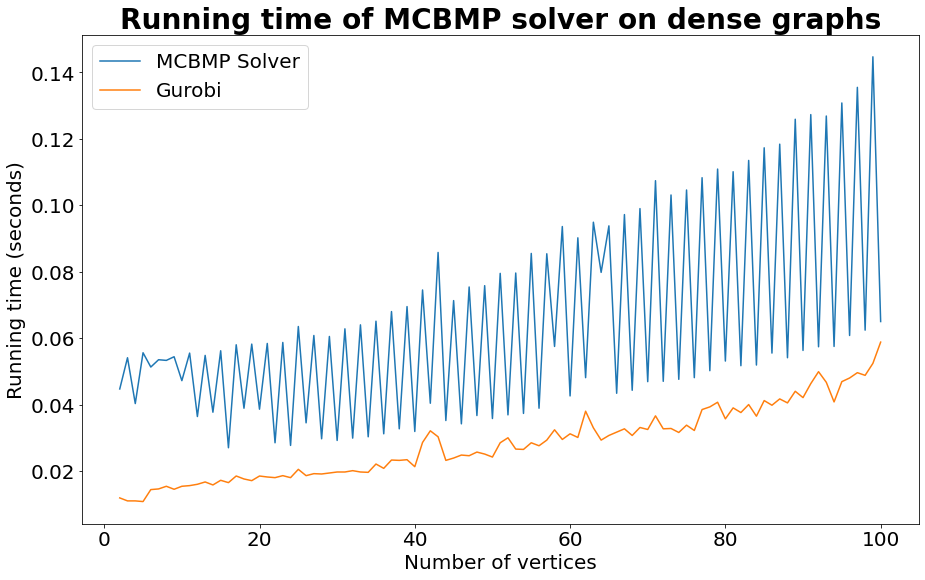

In [42]:
# Plot results
# Source: https://stackoverflow.com/a/37266356/18307616
plt.figure(figsize=(15,9))
lists = sorted(times_brute_dense.items()) # sorted by key, return a list of tuples

x, y = zip(*lists) # unpack a list of pairs into two tuples

plt.plot(x, y)

lists = sorted(times_gurobi_dense.items())

x, y = zip(*lists) # unpack a list of pairs into two tuples

plt.plot(x, y)


plt.legend(['MCBMP Solver', 'Gurobi'], prop={'size':20})
plt.title("Running time of MCBMP solver on dense graphs", size=28, weight='bold')
plt.xlabel("Number of vertices", size=20)
plt.ylabel("Running time (seconds)", size=20)
plt.tick_params(axis='x', labelsize=20)
plt.tick_params(axis='y', labelsize=20)
plt.show()

In [40]:
'''
Test of budgeted matching polynomial program on sparse graphs
Results get saved in dict times_brute and times_gurobi
'''
# Sparse Graphs
times_brute = {}
times_gurobi = {}
for n in range(2,101):
    print("iterationnumber", n)
    running_time_bruteforce = 0
    running_time_gurobi = 0
    for i in range(5):
        g = generateRandomRestricted(n, 2/n, 10)
        gurobi = restricted_graph_to_gurobi(g, 3*n)
        start = time.time()
        budgetedMatchingPolynomial(g, 3*n)
        end = time.time()
        running_time_bruteforce += end - start
        
        start = time.time()
        gurobi.optimize()
        end = time.time()
        running_time_gurobi += end - start
    times_brute[n] = running_time_bruteforce / 5
    times_gurobi[n] = running_time_gurobi / 5

iterationnumber 2
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 3 rows, 1 columns and 3 nonzeros
Model fingerprint: 0xcd0982b4
Variable types: 0 continuous, 1 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 6e+00]
Found heuristic solution: objective -0.0000000
Presolve removed 3 rows and 1 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.01 seconds
Thread count was 1 (of 12 available processors)

Solution count 1: -0 
No other solutions better than -0

Optimal solution found (tolerance 1.00e-04)
Best objective -0.000000000000e+00, best bound -0.000000000000e+00, gap 0.0000%
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to


Optimal solution found (tolerance 1.00e-04)
Best objective 1.000000000000e+00, best bound 1.000000000000e+00, gap 0.0000%
iterationnumber 4
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 5 rows, 3 columns and 9 nonzeros
Model fingerprint: 0x6f9e0ddb
Variable types: 0 continuous, 3 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+01]
Found heuristic solution: objective 1.0000000
Presolve removed 5 rows and 3 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.01 seconds
Thread count was 1 (of 12 available processors)

Solution count 1: 1 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.000000000000e+00, best bound 1.000000000000e+00, gap 0.0000%
Gurobi Optimizer version 9.1.2 build

Thread count was 1 (of 12 available processors)

Solution count 1: 1 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.000000000000e+00, best bound 1.000000000000e+00, gap 0.0000%
iterationnumber 6
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 7 rows, 4 columns and 12 nonzeros
Model fingerprint: 0xf2ce2f38
Variable types: 0 continuous, 4 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+01]
Found heuristic solution: objective 1.0000000
Presolve removed 7 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.01 seconds
Thread count was 1 (of 12 available processors)

Solution count 2: 2 1 

Optimal solution found (tolerance 1.00e-04)
Best objective 2.000000000000e+00, best b


Solution count 2: 2 1 

Optimal solution found (tolerance 1.00e-04)
Best objective 2.000000000000e+00, best bound 2.000000000000e+00, gap 0.0000%
iterationnumber 8
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 9 rows, 8 columns and 24 nonzeros
Model fingerprint: 0x281d0f2f
Variable types: 0 continuous, 8 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+01]
Found heuristic solution: objective 2.0000000
Presolve removed 9 rows and 8 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.01 seconds
Thread count was 1 (of 12 available processors)

Solution count 1: 2 

Optimal solution found (tolerance 1.00e-04)
Best objective 2.000000000000e+00, best bound 2.000000000000e+00, gap 0.0000%
Gurobi Opti

Coefficient statistics:
  Matrix range     [1e+00, 1e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 3e+01]
Found heuristic solution: objective 3.0000000
Presolve removed 1 rows and 1 columns
Presolve time: 0.00s
Presolved: 9 rows, 12 columns, 35 nonzeros
Found heuristic solution: objective 3.0000000
Variable types: 0 continuous, 12 integer (12 binary)

Root relaxation: cutoff, 5 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0     cutoff    0         3.00000    3.00000  0.00%     -    0s

Explored 0 nodes (5 simplex iterations) in 0.01 seconds
Thread count was 12 (of 12 available processors)

Solution count 2: 3 3 

Optimal solution found (tolerance 1.00e-04)
Best objective 3.000000000000e+00, best bound 3.000000000000e+00, gap 0.0000%
iterationnumber 10
Gurobi Optimizer version 9.1.2 build v9.1

Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 12 rows, 14 columns and 42 nonzeros
Model fingerprint: 0x093b47c7
Variable types: 0 continuous, 14 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 3e+01]
Found heuristic solution: objective 3.0000000
Presolve removed 5 rows and 3 columns
Presolve time: 0.00s
Presolved: 7 rows, 11 columns, 29 nonzeros
Variable types: 0 continuous, 11 integer (11 binary)

Root relaxation: cutoff, 0 iterations, 0.00 seconds

Explored 0 nodes (0 simplex iterations) in 0.01 seconds
Thread count was 12 (of 12 available processors)

Solution count 1: 3 

Optimal solution found (tolerance 1.00e-04)
Best objective 3.000000000000e+00, best bound 3.000000000000e+00, gap 0.0000%
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread 

Optimize a model with 14 rows, 17 columns and 51 nonzeros
Model fingerprint: 0x7df50a6d
Variable types: 0 continuous, 17 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 4e+01]
Found heuristic solution: objective 4.0000000
Presolve removed 2 rows and 0 columns
Presolve time: 0.00s
Presolved: 12 rows, 17 columns, 50 nonzeros
Variable types: 0 continuous, 17 integer (17 binary)

Root relaxation: objective 5.000000e+00, 7 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0       5.0000000    5.00000  0.00%     -    0s

Explored 0 nodes (7 simplex iterations) in 0.01 seconds
Thread count was 12 (of 12 available processors)

Solution count 2: 5 4 

Optimal solution found (tolerance 1.00e-04)
Best objective 5.0000000000


Solution count 1: 4 

Optimal solution found (tolerance 1.00e-04)
Best objective 4.000000000000e+00, best bound 4.000000000000e+00, gap 0.0000%
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 15 rows, 8 columns and 24 nonzeros
Model fingerprint: 0xb97eff63
Variable types: 0 continuous, 8 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 4e+01]
Found heuristic solution: objective 4.0000000
Presolve removed 15 rows and 8 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.01 seconds
Thread count was 1 (of 12 available processors)

Solution count 1: 4 

Optimal solution found (tolerance 1.00e-04)
Best objective 4.000000000000e+00, best bound 4.000000000000e+00, gap 0.0000%
iterationnumber 15
Gurobi Opt

Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 17 rows, 16 columns and 48 nonzeros
Model fingerprint: 0x7c4e056b
Variable types: 0 continuous, 16 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+01]
Found heuristic solution: objective 4.0000000
Presolve removed 17 rows and 16 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.01 seconds
Thread count was 1 (of 12 available processors)

Solution count 2: 5 4 

Optimal solution found (tolerance 1.00e-04)
Best objective 5.000000000000e+00, best bound 5.000000000000e+00, gap 0.0000%
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 17 rows, 17 columns and 51 nonzeros
Model fingerprint: 0x58b5c4be
Var

Variable types: 0 continuous, 14 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+01]
Found heuristic solution: objective 4.0000000
Presolve removed 10 rows and 3 columns
Presolve time: 0.00s
Presolved: 8 rows, 11 columns, 27 nonzeros
Found heuristic solution: objective 5.0000000
Variable types: 0 continuous, 11 integer (11 binary)

Root relaxation: cutoff, 0 iterations, 0.00 seconds

Explored 0 nodes (0 simplex iterations) in 0.01 seconds
Thread count was 12 (of 12 available processors)

Solution count 2: 5 4 

Optimal solution found (tolerance 1.00e-04)
Best objective 5.000000000000e+00, best bound 5.000000000000e+00, gap 0.0000%
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 18 rows, 20 columns and 60 nonzeros
Model fingerprint: 0x18857bae
Variable type

Found heuristic solution: objective 6.0000000
Presolve removed 12 rows and 9 columns
Presolve time: 0.00s
Presolved: 8 rows, 13 columns, 29 nonzeros
Found heuristic solution: objective 6.0000000
Variable types: 0 continuous, 13 integer (13 binary)

Root relaxation: objective 7.200000e+00, 4 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    7.20000    0    1    6.00000    7.20000  20.0%     -    0s
H    0     0                       7.0000000    7.20000  2.86%     -    0s
     0     0    7.20000    0    1    7.00000    7.20000  2.86%     -    0s

Explored 1 nodes (4 simplex iterations) in 0.01 seconds
Thread count was 12 (of 12 available processors)

Solution count 3: 7 6 6 

Optimal solution found (tolerance 1.00e-04)
Best objective 7.000000000000e+00, best bound 7.000000000000e+00, gap 0.0000%
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win

Root relaxation: objective 6.500000e+00, 4 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    6.50000    0    1    5.00000    6.50000  30.0%     -    0s
H    0     0                       6.0000000    6.50000  8.33%     -    0s
     0     0    6.50000    0    1    6.00000    6.50000  8.33%     -    0s

Explored 1 nodes (4 simplex iterations) in 0.01 seconds
Thread count was 12 (of 12 available processors)

Solution count 2: 6 5 

Optimal solution found (tolerance 1.00e-04)
Best objective 6.000000000000e+00, best bound 6.000000000000e+00, gap 0.0000%
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 21 rows, 26 columns and 78 nonzeros
Model fingerprint: 0x4c78c18f
Variable types: 0 continuous, 26 integer (0 binary)
Coefficient statistics:
  Mat

 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    7.15385    0    1    6.00000    7.15385  19.2%     -    0s
H    0     0                       7.0000000    7.15385  2.20%     -    0s
     0     0    7.15385    0    1    7.00000    7.15385  2.20%     -    0s

Explored 1 nodes (8 simplex iterations) in 0.01 seconds
Thread count was 12 (of 12 available processors)

Solution count 2: 7 6 

Optimal solution found (tolerance 1.00e-04)
Best objective 7.000000000000e+00, best bound 7.000000000000e+00, gap 0.0000%
iterationnumber 22
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 23 rows, 22 columns and 66 nonzeros
Model fingerprint: 0xaee29f7b
Variable types: 0 continuous, 22 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00,

Best objective 9.000000000000e+00, best bound 9.000000000000e+00, gap 0.0000%
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 24 rows, 24 columns and 72 nonzeros
Model fingerprint: 0x7f755c37
Variable types: 0 continuous, 24 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 7e+01]
Found heuristic solution: objective 6.0000000
Presolve removed 14 rows and 9 columns
Presolve time: 0.00s
Presolved: 10 rows, 15 columns, 37 nonzeros
Found heuristic solution: objective 7.0000000
Variable types: 0 continuous, 15 integer (14 binary)

Root relaxation: objective 8.047619e+00, 6 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0       

Found heuristic solution: objective 7.0000000
Presolve removed 17 rows and 13 columns
Presolve time: 0.00s
Presolved: 8 rows, 13 columns, 29 nonzeros
Found heuristic solution: objective 8.0000000
Variable types: 0 continuous, 13 integer (12 binary)

Root relaxation: cutoff, 4 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0     cutoff    0         8.00000    8.00000  0.00%     -    0s

Explored 0 nodes (4 simplex iterations) in 0.01 seconds
Thread count was 12 (of 12 available processors)

Solution count 2: 8 7 

Optimal solution found (tolerance 1.00e-04)
Best objective 8.000000000000e+00, best bound 8.000000000000e+00, gap 0.0000%
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 25 rows, 24 columns and 72 nonzeros
Model fingerprint: 0xea5dad

Optimize a model with 27 rows, 38 columns and 114 nonzeros
Model fingerprint: 0x4e7939ba
Variable types: 0 continuous, 38 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 8e+01]
Found heuristic solution: objective 8.0000000
Presolve removed 10 rows and 12 columns
Presolve time: 0.00s
Presolved: 17 rows, 26 columns, 69 nonzeros
Found heuristic solution: objective 9.0000000
Variable types: 0 continuous, 26 integer (26 binary)

Root relaxation: cutoff, 5 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0     cutoff    0         9.00000    9.00000  0.00%     -    0s

Explored 0 nodes (5 simplex iterations) in 0.01 seconds
Thread count was 12 (of 12 available processors)

Solution count 2: 9 8 

Optimal solution found (tolerance 1.00

Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 28 rows, 29 columns and 87 nonzeros
Model fingerprint: 0x6fd43c0f
Variable types: 0 continuous, 29 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 8e+01]
Found heuristic solution: objective 9.0000000
Presolve removed 20 rows and 15 columns
Presolve time: 0.00s
Presolved: 8 rows, 14 columns, 29 nonzeros
Found heuristic solution: objective 10.0000000
Variable types: 0 continuous, 14 integer (13 binary)

Root relaxation: cutoff, 3 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0     cutoff    0        10.00000   10.00000  0.00%     -    0s

Explored 0 nodes (3 simplex iterations) in 0.01 seconds
Thread count was 12 (of 12 availabl


Root relaxation: cutoff, 7 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0     cutoff    0         9.00000    9.00000  0.00%     -    0s

Explored 0 nodes (7 simplex iterations) in 0.01 seconds
Thread count was 12 (of 12 available processors)

Solution count 2: 9 9 

Optimal solution found (tolerance 1.00e-04)
Best objective 9.000000000000e+00, best bound 9.000000000000e+00, gap 0.0000%
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 29 rows, 33 columns and 99 nonzeros
Model fingerprint: 0xb11692d6
Variable types: 0 continuous, 33 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 8e+01]
Found heuristic solution: objectiv


Explored 0 nodes (5 simplex iterations) in 0.01 seconds
Thread count was 12 (of 12 available processors)

Solution count 3: 11 10 8 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.100000000000e+01, best bound 1.100000000000e+01, gap 0.0000%
iterationnumber 30
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 31 rows, 31 columns and 93 nonzeros
Model fingerprint: 0xc5ed81b5
Variable types: 0 continuous, 31 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 9e+01]
Found heuristic solution: objective 9.0000000
Presolve removed 24 rows and 16 columns
Presolve time: 0.00s
Presolved: 7 rows, 15 columns, 29 nonzeros
Found heuristic solution: objective 10.0000000
Variable types: 0 continuous, 15 integer (13 binary)

Root relaxation: objective 1.108333e+01,


Root relaxation: objective 1.166667e+01, 10 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   11.66667    0    3   10.00000   11.66667  16.7%     -    0s
H    0     0                      11.0000000   11.66667  6.06%     -    0s
     0     0   11.66667    0    3   11.00000   11.66667  6.06%     -    0s

Explored 1 nodes (10 simplex iterations) in 0.02 seconds
Thread count was 12 (of 12 available processors)

Solution count 3: 11 10 10 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.100000000000e+01, best bound 1.100000000000e+01, gap 0.0000%
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 32 rows, 33 columns and 99 nonzeros
Model fingerprint: 0x533b99dc
Variable types: 0 continuous, 33 integer (0 binary)
Coefficient statistic

 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   10.81818    0    5    9.00000   10.81818  20.2%     -    0s
H    0     0                      10.0000000   10.81818  8.18%     -    0s
     0     0   10.81818    0    5   10.00000   10.81818  8.18%     -    0s

Explored 1 nodes (9 simplex iterations) in 0.01 seconds
Thread count was 12 (of 12 available processors)

Solution count 3: 10 9 8 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.000000000000e+01, best bound 1.000000000000e+01, gap 0.0000%
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 33 rows, 26 columns and 78 nonzeros
Model fingerprint: 0xb6a17ba9
Variable types: 0 continuous, 26 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+02]
Found he

  Matrix range     [1e+00, 1e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+02]
Found heuristic solution: objective 10.0000000
Presolve removed 25 rows and 9 columns
Presolve time: 0.00s
Presolved: 9 rows, 16 columns, 33 nonzeros
Found heuristic solution: objective 10.0000000
Variable types: 0 continuous, 16 integer (15 binary)

Root relaxation: objective 1.127778e+01, 5 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   11.27778    0    5   10.00000   11.27778  12.8%     -    0s
H    0     0                      11.0000000   11.27778  2.53%     -    0s
     0     0   11.27778    0    5   11.00000   11.27778  2.53%     -    0s

Explored 1 nodes (5 simplex iterations) in 0.01 seconds
Thread count was 12 (of 12 available processors)

Solution count 3: 11 10 10 

Optimal solution found (toleranc

Optimize a model with 36 rows, 29 columns and 87 nonzeros
Model fingerprint: 0xbe0cbe16
Variable types: 0 continuous, 29 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+02]
Found heuristic solution: objective 10.0000000
Presolve removed 24 rows and 10 columns
Presolve time: 0.00s
Presolved: 12 rows, 19 columns, 44 nonzeros
Found heuristic solution: objective 10.0000000
Variable types: 0 continuous, 19 integer (18 binary)

Root relaxation: objective 1.115000e+01, 10 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   11.00000    0    2   10.00000   11.00000  10.0%     -    0s
H    0     0                      11.0000000   11.00000  0.00%     -    0s
     0     0   11.00000    0    2   11.00000   11.00000  0.00%     -    0s



Variable types: 0 continuous, 33 integer (33 binary)

Root relaxation: objective 1.347059e+01, 13 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   13.47059    0    5   12.00000   13.47059  12.3%     -    0s
H    0     0                      13.0000000   13.47059  3.62%     -    0s
     0     0   13.47059    0    5   13.00000   13.47059  3.62%     -    0s

Explored 1 nodes (13 simplex iterations) in 0.01 seconds
Thread count was 12 (of 12 available processors)

Solution count 3: 13 12 11 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.300000000000e+01, best bound 1.300000000000e+01, gap 0.0000%
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 37 rows, 24 columns and 72 nonzeros
Model fingerprint: 0xa70b98a4
Variable types: 0 co

Optimize a model with 38 rows, 40 columns and 120 nonzeros
Model fingerprint: 0xaa0da511
Variable types: 0 continuous, 40 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+02]
Found heuristic solution: objective 10.0000000
Presolve removed 22 rows and 12 columns
Presolve time: 0.00s
Presolved: 16 rows, 28 columns, 74 nonzeros
Found heuristic solution: objective 12.0000000
Variable types: 0 continuous, 28 integer (27 binary)

Root relaxation: objective 1.300000e+01, 14 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0      13.0000000   13.00000  0.00%     -    0s

Explored 0 nodes (15 simplex iterations) in 0.01 seconds
Thread count was 12 (of 12 available processors)

Solution count 3: 13 12 10 

Optimal solut

Found heuristic solution: objective 11.0000000
Presolve removed 22 rows and 11 columns
Presolve time: 0.00s
Presolved: 17 rows, 28 columns, 70 nonzeros
Found heuristic solution: objective 11.0000000
Variable types: 0 continuous, 28 integer (28 binary)

Root relaxation: objective 1.338095e+01, 9 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   13.38095    0    5   11.00000   13.38095  21.6%     -    0s
H    0     0                      13.0000000   13.38095  2.93%     -    0s
     0     0   13.38095    0    5   13.00000   13.38095  2.93%     -    0s

Explored 1 nodes (9 simplex iterations) in 0.01 seconds
Thread count was 12 (of 12 available processors)

Solution count 3: 13 11 11 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.300000000000e+01, best bound 1.300000000000e+01, gap 0.0000%
iterationnumber 39
Gurobi Optimizer version 

Variable types: 0 continuous, 36 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+02]
Found heuristic solution: objective 10.0000000
Presolve removed 23 rows and 12 columns
Presolve time: 0.00s
Presolved: 18 rows, 24 columns, 63 nonzeros
Found heuristic solution: objective 11.0000000
Variable types: 0 continuous, 24 integer (23 binary)

Root relaxation: objective 1.310526e+01, 11 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   13.10526    0    3   11.00000   13.10526  19.1%     -    0s
H    0     0                      12.0000000   13.10526  9.21%     -    0s
H    0     0                      13.0000000   13.10526  0.81%     -    0s
     0     0   13.10526    0    3   13.00000   13.10526  0.81%     -    0s

Explored 1 no

Optimize a model with 42 rows, 34 columns and 102 nonzeros
Model fingerprint: 0xa4fdd069
Variable types: 0 continuous, 34 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+02]
Found heuristic solution: objective 12.0000000
Presolve removed 28 rows and 12 columns
Presolve time: 0.00s
Presolved: 14 rows, 22 columns, 51 nonzeros
Found heuristic solution: objective 14.0000000
Variable types: 0 continuous, 22 integer (20 binary)

Root relaxation: objective 1.500000e+01, 6 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   15.00000    0    2   14.00000   15.00000  7.14%     -    0s
H    0     0                      15.0000000   15.00000  0.00%     -    0s
     0     0   15.00000    0    2   15.00000   15.00000  0.00%     -    0s



Presolved: 27 rows, 42 columns, 117 nonzeros
Found heuristic solution: objective 12.0000000
Variable types: 0 continuous, 42 integer (42 binary)

Root relaxation: objective 1.538462e+01, 16 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   15.38462    0    1   12.00000   15.38462  28.2%     -    0s
H    0     0                      15.0000000   15.38462  2.56%     -    0s
     0     0   15.38462    0    1   15.00000   15.38462  2.56%     -    0s

Explored 1 nodes (16 simplex iterations) in 0.01 seconds
Thread count was 12 (of 12 available processors)

Solution count 3: 15 12 11 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.500000000000e+01, best bound 1.500000000000e+01, gap 0.0000%
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model

  RHS range        [1e+00, 1e+02]
Found heuristic solution: objective 12.0000000
Presolve removed 25 rows and 13 columns
Presolve time: 0.00s
Presolved: 20 rows, 28 columns, 69 nonzeros
Found heuristic solution: objective 14.0000000
Variable types: 0 continuous, 28 integer (28 binary)

Root relaxation: objective 1.550000e+01, 20 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   15.50000    0    1   14.00000   15.50000  10.7%     -    0s
H    0     0                      15.0000000   15.50000  3.33%     -    0s
     0     0   15.50000    0    1   15.00000   15.50000  3.33%     -    0s

Explored 1 nodes (20 simplex iterations) in 0.01 seconds
Thread count was 12 (of 12 available processors)

Solution count 3: 15 14 12 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.500000000000e+01, best bound 1.500000000000e+01, gap 0.0000%
Gurobi O

H    0     0                      15.0000000   15.66667  4.44%     -    0s
     0     0   15.66667    0    3   15.00000   15.66667  4.44%     -    0s

Explored 1 nodes (14 simplex iterations) in 0.01 seconds
Thread count was 12 (of 12 available processors)

Solution count 3: 15 14 13 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.500000000000e+01, best bound 1.500000000000e+01, gap 0.0000%
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 46 rows, 49 columns and 147 nonzeros
Model fingerprint: 0x6bed1ba8
Variable types: 0 continuous, 49 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+02]
Found heuristic solution: objective 14.0000000
Presolve removed 28 rows and 18 columns
Presolve time: 0.00s
Presolved: 18 rows, 31 columns, 78 nonzeros
Found

Thread count was 12 (of 12 available processors)

Solution count 2: 14 13 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.400000000000e+01, best bound 1.400000000000e+01, gap 0.0000%
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 47 rows, 45 columns and 135 nonzeros
Model fingerprint: 0xaa9c946d
Variable types: 0 continuous, 45 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+02]
Found heuristic solution: objective 13.0000000
Presolve removed 33 rows and 23 columns
Presolve time: 0.00s
Presolved: 14 rows, 22 columns, 51 nonzeros
Found heuristic solution: objective 15.0000000
Variable types: 0 continuous, 22 integer (20 binary)

Root relaxation: objective 1.600000e+01, 7 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Object

Optimize a model with 48 rows, 47 columns and 141 nonzeros
Model fingerprint: 0xd204f2a9
Variable types: 0 continuous, 47 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+02]
Found heuristic solution: objective 14.0000000
Presolve removed 30 rows and 19 columns
Presolve time: 0.00s
Presolved: 18 rows, 28 columns, 66 nonzeros
Found heuristic solution: objective 15.0000000
Variable types: 0 continuous, 28 integer (26 binary)

Root relaxation: objective 1.900000e+01, 6 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0      19.0000000   19.00000  0.00%     -    0s

Explored 0 nodes (6 simplex iterations) in 0.01 seconds
Thread count was 12 (of 12 available processors)

Solution count 3: 19 15 14 

Optimal solutio

  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+02]
Found heuristic solution: objective 13.0000000
Presolve removed 28 rows and 13 columns
Presolve time: 0.00s
Presolved: 22 rows, 37 columns, 95 nonzeros
Found heuristic solution: objective 14.0000000
Variable types: 0 continuous, 37 integer (35 binary)

Root relaxation: objective 1.814286e+01, 15 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   18.14286    0    5   14.00000   18.14286  29.6%     -    0s
H    0     0                      17.0000000   18.14286  6.72%     -    0s
H    0     0                      18.0000000   18.14286  0.79%     -    0s
     0     0   18.14286    0    5   18.00000   18.14286  0.79%     -    0s

Explored 1 nodes (15 simplex iterations) in 0.01 seconds
Thread count was 12 (of 12 available processors)

Solution count 4: 18 17 14 13 

Optimal solution f

Optimize a model with 51 rows, 54 columns and 162 nonzeros
Model fingerprint: 0xe251f449
Variable types: 0 continuous, 54 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+02]
Found heuristic solution: objective 14.0000000
Presolve removed 31 rows and 22 columns
Presolve time: 0.00s
Presolved: 20 rows, 32 columns, 79 nonzeros
Found heuristic solution: objective 16.0000000
Variable types: 0 continuous, 32 integer (30 binary)

Root relaxation: objective 1.806250e+01, 12 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   18.06250    0    5   16.00000   18.06250  12.9%     -    0s
H    0     0                      18.0000000   18.06250  0.35%     -    0s
     0     0   18.06250    0    5   18.00000   18.06250  0.35%     -    0s


Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+02]
Found heuristic solution: objective 14.0000000
Presolve removed 37 rows and 21 columns
Presolve time: 0.00s
Presolved: 15 rows, 26 columns, 58 nonzeros
Found heuristic solution: objective 15.0000000
Variable types: 0 continuous, 26 integer (23 binary)

Root relaxation: objective 1.753846e+01, 10 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   17.53846    0    1   15.00000   17.53846  16.9%     -    0s
H    0     0                      17.0000000   17.53846  3.17%     -    0s
     0     0   17.53846    0    1   17.00000   17.53846  3.17%     -    0s

Explored 1 nodes (10 simplex iterations) in 0.01 seconds
Thread count was 12 (of 12 available processors)

Solution count 3: 17 15 14 

Opti

     0     0   20.41667    0    3   20.00000   20.41667  2.08%     -    0s

Explored 1 nodes (6 simplex iterations) in 0.01 seconds
Thread count was 12 (of 12 available processors)

Solution count 3: 20 19 18 

Optimal solution found (tolerance 1.00e-04)
Best objective 2.000000000000e+01, best bound 2.000000000000e+01, gap 0.0000%
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 53 rows, 46 columns and 138 nonzeros
Model fingerprint: 0x4554481b
Variable types: 0 continuous, 46 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+02]
Found heuristic solution: objective 15.0000000
Presolve removed 30 rows and 9 columns
Presolve time: 0.00s
Presolved: 23 rows, 37 columns, 95 nonzeros
Variable types: 0 continuous, 37 integer (37 binary)

Root relaxation: objective 1


Explored 1 nodes (9 simplex iterations) in 0.01 seconds
Thread count was 12 (of 12 available processors)

Solution count 3: 18 17 14 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.800000000000e+01, best bound 1.800000000000e+01, gap 0.0000%
iterationnumber 54
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 55 rows, 51 columns and 153 nonzeros
Model fingerprint: 0xb50b6fa0
Variable types: 0 continuous, 51 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+02]
Found heuristic solution: objective 15.0000000
Presolve removed 30 rows and 13 columns
Presolve time: 0.00s
Presolved: 25 rows, 38 columns, 98 nonzeros
Found heuristic solution: objective 16.0000000
Variable types: 0 continuous, 38 integer (38 binary)

Root relaxation: objective 1.725000e


Solution count 3: 20 19 18 

Optimal solution found (tolerance 1.00e-04)
Best objective 2.000000000000e+01, best bound 2.000000000000e+01, gap 0.0000%
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 56 rows, 47 columns and 141 nonzeros
Model fingerprint: 0x420646f1
Variable types: 0 continuous, 47 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+02]
Found heuristic solution: objective 16.0000000
Presolve removed 42 rows and 21 columns
Presolve time: 0.00s
Presolved: 14 rows, 26 columns, 55 nonzeros
Found heuristic solution: objective 18.0000000
Variable types: 0 continuous, 26 integer (24 binary)

Root relaxation: cutoff, 4 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf |

Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 57 rows, 61 columns and 183 nonzeros
Model fingerprint: 0xe04e0c91
Variable types: 0 continuous, 61 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+02]
Found heuristic solution: objective 16.0000000
Presolve removed 18 rows and 9 columns
Presolve time: 0.00s
Presolved: 39 rows, 52 columns, 147 nonzeros
Found heuristic solution: objective 17.0000000
Variable types: 0 continuous, 52 integer (52 binary)

Root relaxation: objective 2.011111e+01, 22 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   20.11111    0    3   17.00000   20.11111  18.3%     -    0s
H    0     0                      20.0000000   20.11111  0.56%     -    

Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 58 rows, 60 columns and 180 nonzeros
Model fingerprint: 0xb502ba59
Variable types: 0 continuous, 60 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+02]
Found heuristic solution: objective 18.0000000
Presolve removed 39 rows and 29 columns
Presolve time: 0.00s
Presolved: 19 rows, 31 columns, 73 nonzeros
Found heuristic solution: objective 18.0000000
Variable types: 0 continuous, 31 integer (27 binary)

Root relaxation: objective 2.015385e+01, 8 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   20.15385    0    3   18.00000   20.15385  12.0%     -    0s
H    0     0                      20.0000000   20.15385  0.77%     -    0

Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+02]
Found heuristic solution: objective 18.0000000
Presolve removed 34 rows and 18 columns
Presolve time: 0.00s
Presolved: 26 rows, 40 columns, 105 nonzeros
Found heuristic solution: objective 18.0000000
Variable types: 0 continuous, 40 integer (38 binary)

Root relaxation: objective 2.077778e+01, 17 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   20.77778    0    3   18.00000   20.77778  15.4%     -    0s
H    0     0                      20.0000000   20.77778  3.89%     -    0s
     0     0   20.77778    0    3   20.00000   20.77778  3.89%     -    0s

Explored 1 nodes (17 simplex iterations) in 0.01 seconds
Thread count was 12 (of 12 available processors)

Solution count 3: 20 18 18 

Opt


    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0      21.0000000   21.00000  0.00%     -    0s

Explored 0 nodes (13 simplex iterations) in 0.01 seconds
Thread count was 12 (of 12 available processors)

Solution count 3: 21 19 17 

Optimal solution found (tolerance 1.00e-04)
Best objective 2.100000000000e+01, best bound 2.100000000000e+01, gap 0.0000%
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 61 rows, 49 columns and 147 nonzeros
Model fingerprint: 0xf17cad96
Variable types: 0 continuous, 49 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+02]
Found heuristic solution: objective 16.0000000
Presolve removed 38 rows and 13 c


Root relaxation: objective 2.321429e+01, 9 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   23.21429    0    1   19.00000   23.21429  22.2%     -    0s
H    0     0                      22.0000000   23.21429  5.52%     -    0s
H    0     0                      23.0000000   23.21429  0.93%     -    0s
     0     0   23.21429    0    1   23.00000   23.21429  0.93%     -    0s

Explored 1 nodes (9 simplex iterations) in 0.01 seconds
Thread count was 12 (of 12 available processors)

Solution count 4: 23 22 19 17 

Optimal solution found (tolerance 1.00e-04)
Best objective 2.300000000000e+01, best bound 2.300000000000e+01, gap 0.0000%
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 62 rows, 65 columns and 195 nonzeros
Model fingerprint: 0xfb3c6

Found heuristic solution: objective 17.0000000
Presolve removed 31 rows and 28 columns
Presolve time: 0.00s
Presolved: 32 rows, 51 columns, 126 nonzeros
Found heuristic solution: objective 18.0000000
Variable types: 0 continuous, 51 integer (51 binary)

Root relaxation: objective 2.383333e+01, 26 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   23.83333    0    1   18.00000   23.83333  32.4%     -    0s
H    0     0                      23.0000000   23.83333  3.62%     -    0s
     0     0   23.83333    0    1   23.00000   23.83333  3.62%     -    0s

Explored 1 nodes (26 simplex iterations) in 0.01 seconds
Thread count was 12 (of 12 available processors)

Solution count 3: 23 18 17 

Optimal solution found (tolerance 1.00e-04)
Best objective 2.300000000000e+01, best bound 2.300000000000e+01, gap 0.0000%
Gurobi Optimizer version 9.1.2 build v9.1

Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+02]
Found heuristic solution: objective 18.0000000
Presolve removed 47 rows and 36 columns
Presolve time: 0.00s
Presolved: 17 rows, 33 columns, 72 nonzeros
Found heuristic solution: objective 19.0000000
Variable types: 0 continuous, 33 integer (30 binary)

Root relaxation: objective 2.221429e+01, 8 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   22.21429    0    1   19.00000   22.21429  16.9%     -    0s
H    0     0                      21.0000000   22.21429  5.78%     -    0s
H    0     0                      22.0000000   22.21429  0.97%     -    0s
     0     0   22.21429    0    1   22.00000   22.21429  0.97%     -    0s

Explored 1 nodes (8 simplex iterations) in 0.01 seconds
Thread cou

Optimize a model with 66 rows, 67 columns and 201 nonzeros
Model fingerprint: 0x4c3ea7ca
Variable types: 0 continuous, 67 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+02]
Found heuristic solution: objective 21.0000000
Presolve removed 32 rows and 10 columns
Presolve time: 0.00s
Presolved: 34 rows, 57 columns, 152 nonzeros
Found heuristic solution: objective 21.0000000
Variable types: 0 continuous, 57 integer (56 binary)

Root relaxation: objective 2.368750e+01, 23 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   23.68750    0    1   21.00000   23.68750  12.8%     -    0s
H    0     0                      23.0000000   23.68750  2.99%     -    0s
     0     0   23.68750    0    1   23.00000   23.68750  2.99%     -    0s

Variable types: 0 continuous, 60 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+02]
Found heuristic solution: objective 21.0000000
Presolve removed 39 rows and 19 columns
Presolve time: 0.00s
Presolved: 28 rows, 41 columns, 101 nonzeros
Found heuristic solution: objective 21.0000000
Variable types: 0 continuous, 41 integer (38 binary)

Root relaxation: objective 2.353333e+01, 12 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   23.53333    0    3   21.00000   23.53333  12.1%     -    0s
H    0     0                      23.0000000   23.53333  2.32%     -    0s
     0     0   23.53333    0    3   23.00000   23.53333  2.32%     -    0s

Explored 1 nodes (12 simplex iterations) in 0.01 seconds
Thread count was 12 (of 12 ava

  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+02]
Found heuristic solution: objective 21.0000000
Presolve removed 46 rows and 19 columns
Presolve time: 0.00s
Presolved: 22 rows, 41 columns, 95 nonzeros
Found heuristic solution: objective 22.0000000
Variable types: 0 continuous, 41 integer (40 binary)

Root relaxation: objective 2.356250e+01, 14 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   23.56250    0    1   22.00000   23.56250  7.10%     -    0s
H    0     0                      23.0000000   23.56250  2.45%     -    0s
     0     0   23.56250    0    1   23.00000   23.56250  2.45%     -    0s

Explored 1 nodes (14 simplex iterations) in 0.01 seconds
Thread count was 12 (of 12 available processors)

Solution count 3: 23 22 21 

Optimal solution found (tolerance 1.00e-04)
Best objective 2.300000000000e+01, best bound 2.3000


Explored 1 nodes (15 simplex iterations) in 0.01 seconds
Thread count was 12 (of 12 available processors)

Solution count 3: 24 23 21 

Optimal solution found (tolerance 1.00e-04)
Best objective 2.400000000000e+01, best bound 2.400000000000e+01, gap 0.0000%
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 69 rows, 71 columns and 213 nonzeros
Model fingerprint: 0x5cc2857c
Variable types: 0 continuous, 71 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+02]
Found heuristic solution: objective 20.0000000
Presolve removed 41 rows and 27 columns
Presolve time: 0.00s
Presolved: 28 rows, 44 columns, 108 nonzeros
Found heuristic solution: objective 23.0000000
Variable types: 0 continuous, 44 integer (42 binary)

Root relaxation: objective 2.600000e+01, 19 iteration


Explored 1 nodes (14 simplex iterations) in 0.01 seconds
Thread count was 12 (of 12 available processors)

Solution count 3: 25 24 21 

Optimal solution found (tolerance 1.00e-04)
Best objective 2.500000000000e+01, best bound 2.500000000000e+01, gap 0.0000%
iterationnumber 70
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 71 rows, 69 columns and 207 nonzeros
Model fingerprint: 0x364ffc20
Variable types: 0 continuous, 69 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+02]
Found heuristic solution: objective 20.0000000
Presolve removed 39 rows and 16 columns
Presolve time: 0.00s
Presolved: 32 rows, 53 columns, 137 nonzeros
Found heuristic solution: objective 22.0000000
Variable types: 0 continuous, 53 integer (52 binary)

Root relaxation: objective 2.55172

H    0     0                      26.0000000   26.47059  1.81%     -    0s
     0     0   26.47059    0    7   26.00000   26.47059  1.81%     -    0s

Explored 1 nodes (21 simplex iterations) in 0.02 seconds
Thread count was 12 (of 12 available processors)

Solution count 3: 26 24 23 

Optimal solution found (tolerance 1.00e-04)
Best objective 2.600000000000e+01, best bound 2.600000000000e+01, gap 0.0000%
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 72 rows, 81 columns and 243 nonzeros
Model fingerprint: 0x68b9b3dd
Variable types: 0 continuous, 81 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+02]
Found heuristic solution: objective 21.0000000
Presolve removed 33 rows and 17 columns
Presolve time: 0.00s
Presolved: 39 rows, 64 columns, 173 nonzeros
Foun


     0     0     cutoff    0        24.00000   24.00000  0.00%     -    0s

Explored 0 nodes (4 simplex iterations) in 0.01 seconds
Thread count was 12 (of 12 available processors)

Solution count 2: 24 22 

Optimal solution found (tolerance 1.00e-04)
Best objective 2.400000000000e+01, best bound 2.400000000000e+01, gap 0.0000%
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 73 rows, 66 columns and 198 nonzeros
Model fingerprint: 0x84c914cc
Variable types: 0 continuous, 66 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+02]
Found heuristic solution: objective 22.0000000
Presolve removed 35 rows and 8 columns
Presolve time: 0.00s
Presolved: 38 rows, 58 columns, 155 nonzeros
Found heuristic solution: objective 22.0000000
Variable types: 0 continuous, 58 int

Thread count was 12 (of 12 available processors)

Solution count 3: 24 22 21 

Optimal solution found (tolerance 1.00e-04)
Best objective 2.400000000000e+01, best bound 2.400000000000e+01, gap 0.0000%
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 74 rows, 74 columns and 222 nonzeros
Model fingerprint: 0x95b13802
Variable types: 0 continuous, 74 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+02]
Found heuristic solution: objective 21.0000000
Presolve removed 32 rows and 10 columns
Presolve time: 0.00s
Presolved: 42 rows, 64 columns, 172 nonzeros
Found heuristic solution: objective 23.0000000
Variable types: 0 continuous, 64 integer (63 binary)

Root relaxation: objective 2.661111e+01, 25 iterations, 0.00 seconds

    Nodes    |    Current Node    |     O

Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 75 rows, 64 columns and 192 nonzeros
Model fingerprint: 0xed87c576
Variable types: 0 continuous, 64 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+02]
Found heuristic solution: objective 20.0000000
Presolve removed 60 rows and 37 columns
Presolve time: 0.00s
Presolved: 15 rows, 27 columns, 58 nonzeros
Found heuristic solution: objective 24.0000000
Variable types: 0 continuous, 27 integer (24 binary)

Root relaxation: cutoff, 5 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0     cutoff    0        24.00000   24.00000  0.00%     -    0s

Explored 0 nodes (5 simplex itera

Best objective 2.500000000000e+01, best bound 2.500000000000e+01, gap 0.0000%
iterationnumber 76
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 77 rows, 83 columns and 249 nonzeros
Model fingerprint: 0x382601bb
Variable types: 0 continuous, 83 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+02]
Found heuristic solution: objective 22.0000000
Presolve removed 44 rows and 29 columns
Presolve time: 0.00s
Presolved: 33 rows, 54 columns, 137 nonzeros
Found heuristic solution: objective 25.0000000
Variable types: 0 continuous, 54 integer (52 binary)

Root relaxation: objective 2.811765e+01, 23 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node 

H    0     0                      28.0000000   28.92857  3.32%     -    0s
     0     0   28.92857    0    3   28.00000   28.92857  3.32%     -    0s

Explored 1 nodes (30 simplex iterations) in 0.01 seconds
Thread count was 12 (of 12 available processors)

Solution count 3: 28 24 24 

Optimal solution found (tolerance 1.00e-04)
Best objective 2.800000000000e+01, best bound 2.800000000000e+01, gap 0.0000%
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 78 rows, 84 columns and 252 nonzeros
Model fingerprint: 0xc9b7c6c0
Variable types: 0 continuous, 84 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+02]
Found heuristic solution: objective 21.0000000
Presolve removed 46 rows and 37 columns
Presolve time: 0.00s
Presolved: 32 rows, 47 columns, 117 nonzeros
Foun


    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   27.57143    0    3   25.00000   27.57143  10.3%     -    0s
H    0     0                      27.0000000   27.57143  2.12%     -    0s
     0     0   27.57143    0    3   27.00000   27.57143  2.12%     -    0s

Explored 1 nodes (7 simplex iterations) in 0.01 seconds
Thread count was 12 (of 12 available processors)

Solution count 3: 27 25 22 

Optimal solution found (tolerance 1.00e-04)
Best objective 2.700000000000e+01, best bound 2.700000000000e+01, gap 0.0000%
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 79 rows, 83 columns and 249 nonzeros
Model fingerprint: 0x90bfe5a1
Variable types: 0 continuous, 83 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [1e+00, 1e+00]

Presolve time: 0.00s
Presolved: 43 rows, 65 columns, 172 nonzeros
Found heuristic solution: objective 24.0000000
Variable types: 0 continuous, 65 integer (62 binary)

Root relaxation: objective 3.175000e+01, 19 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   31.75000    0    1   24.00000   31.75000  32.3%     -    0s
H    0     0                      31.0000000   31.75000  2.42%     -    0s
     0     0   31.75000    0    1   31.00000   31.75000  2.42%     -    0s

Explored 1 nodes (19 simplex iterations) in 0.01 seconds
Thread count was 12 (of 12 available processors)

Solution count 3: 31 24 23 

Optimal solution found (tolerance 1.00e-04)
Best objective 3.100000000000e+01, best bound 3.100000000000e+01, gap 0.0000%
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 thr

Presolve time: 0.00s
Presolved: 17 rows, 32 columns, 68 nonzeros
Found heuristic solution: objective 25.0000000
Variable types: 0 continuous, 32 integer (26 binary)

Root relaxation: objective 2.846154e+01, 13 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   28.46154    0    1   25.00000   28.46154  13.8%     -    0s
H    0     0                      28.0000000   28.46154  1.65%     -    0s
     0     0   28.46154    0    1   28.00000   28.46154  1.65%     -    0s

Explored 1 nodes (13 simplex iterations) in 0.01 seconds
Thread count was 12 (of 12 available processors)

Solution count 3: 28 25 21 

Optimal solution found (tolerance 1.00e-04)
Best objective 2.800000000000e+01, best bound 2.800000000000e+01, gap 0.0000%
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 thre

Presolve time: 0.00s
Presolved: 23 rows, 42 columns, 94 nonzeros
Found heuristic solution: objective 26.0000000
Variable types: 0 continuous, 42 integer (38 binary)

Root relaxation: objective 2.811111e+01, 13 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   28.11111    0    5   26.00000   28.11111  8.12%     -    0s
H    0     0                      28.0000000   28.11111  0.40%     -    0s
     0     0   28.11111    0    5   28.00000   28.11111  0.40%     -    0s

Explored 1 nodes (13 simplex iterations) in 0.01 seconds
Thread count was 12 (of 12 available processors)

Solution count 3: 28 26 24 

Optimal solution found (tolerance 1.00e-04)
Best objective 2.800000000000e+01, best bound 2.800000000000e+01, gap 0.0000%
iterationnumber 82
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 6 physical cores, 12 logical processors, 

  RHS range        [1e+00, 2e+02]
Found heuristic solution: objective 26.0000000
Presolve removed 57 rows and 34 columns
Presolve time: 0.00s
Presolved: 27 rows, 44 columns, 107 nonzeros
Found heuristic solution: objective 28.0000000
Variable types: 0 continuous, 44 integer (41 binary)

Root relaxation: cutoff, 9 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0     cutoff    0        28.00000   28.00000  0.00%     -    0s

Explored 0 nodes (9 simplex iterations) in 0.01 seconds
Thread count was 12 (of 12 available processors)

Solution count 2: 28 26 

Optimal solution found (tolerance 1.00e-04)
Best objective 2.800000000000e+01, best bound 2.800000000000e+01, gap 0.0000%
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 84 rows, 75 columns and

Model fingerprint: 0x6c2ea473
Variable types: 0 continuous, 85 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 3e+02]
Found heuristic solution: objective 28.0000000
Presolve removed 70 rows and 58 columns
Presolve time: 0.00s
Presolved: 15 rows, 27 columns, 56 nonzeros
Found heuristic solution: objective 31.0000000
Variable types: 0 continuous, 27 integer (21 binary)

Root relaxation: cutoff, 5 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0     cutoff    0        31.00000   31.00000  0.00%     -    0s

Explored 0 nodes (5 simplex iterations) in 0.01 seconds
Thread count was 12 (of 12 available processors)

Solution count 2: 31 28 

Optimal solution found (tolerance 1.00e-04)
Best objective 3.100000000000e+01, best bound 3.1

Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 3e+02]
Found heuristic solution: objective 25.0000000
Presolve removed 48 rows and 20 columns
Presolve time: 0.00s
Presolved: 38 rows, 56 columns, 142 nonzeros
Found heuristic solution: objective 25.0000000
Variable types: 0 continuous, 56 integer (54 binary)

Root relaxation: objective 2.923810e+01, 22 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   29.23810    0    5   25.00000   29.23810  17.0%     -    0s
H    0     0                      28.0000000   29.23810  4.42%     -    0s
H    0     0                      29.0000000   29.23810  0.82%     -    0s
     0     0   29.23810    0    5   29.00000   29.23810  0.82%     -    0s

Explored 1 nodes (22 simplex iterations) in 0.01 seconds
Thread 

Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 87 rows, 96 columns and 288 nonzeros
Model fingerprint: 0x7b995aed
Variable types: 0 continuous, 96 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 3e+02]
Found heuristic solution: objective 26.0000000
Presolve removed 47 rows and 38 columns
Presolve time: 0.00s
Presolved: 40 rows, 58 columns, 153 nonzeros
Found heuristic solution: objective 29.0000000
Variable types: 0 continuous, 58 integer (55 binary)

Root relaxation: objective 3.217647e+01, 29 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   32.17647    0    1   29.00000   32.17647  11.0%     -    0s
H    0     0    


Explored 1 nodes (30 simplex iterations) in 0.01 seconds
Thread count was 12 (of 12 available processors)

Solution count 3: 32 28 28 

Optimal solution found (tolerance 1.00e-04)
Best objective 3.200000000000e+01, best bound 3.200000000000e+01, gap 0.0000%
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 88 rows, 90 columns and 270 nonzeros
Model fingerprint: 0x7a89e110
Variable types: 0 continuous, 90 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 3e+02]
Found heuristic solution: objective 30.0000000
Presolve removed 59 rows and 45 columns
Presolve time: 0.00s
Presolved: 29 rows, 45 columns, 111 nonzeros
Found heuristic solution: objective 30.0000000
Variable types: 0 continuous, 45 integer (40 binary)

Root relaxation: objective 3.300000e+01, 8 iterations


Explored 1 nodes (17 simplex iterations) in 0.02 seconds
Thread count was 12 (of 12 available processors)

Solution count 3: 31 28 26 

Optimal solution found (tolerance 1.00e-04)
Best objective 3.100000000000e+01, best bound 3.100000000000e+01, gap 0.0000%
iterationnumber 89
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 90 rows, 93 columns and 279 nonzeros
Model fingerprint: 0x1249ce3c
Variable types: 0 continuous, 93 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 3e+02]
Found heuristic solution: objective 27.0000000
Presolve removed 65 rows and 51 columns
Presolve time: 0.00s
Presolved: 25 rows, 42 columns, 102 nonzeros
Found heuristic solution: objective 29.0000000
Variable types: 0 continuous, 42 integer (35 binary)

Root relaxation: objective 3.16875

 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0      32.0000000   32.00000  0.00%     -    0s

Explored 0 nodes (15 simplex iterations) in 0.01 seconds
Thread count was 12 (of 12 available processors)

Solution count 3: 32 28 26 

Optimal solution found (tolerance 1.00e-04)
Best objective 3.200000000000e+01, best bound 3.200000000000e+01, gap 0.0000%
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 91 rows, 71 columns and 213 nonzeros
Model fingerprint: 0xf2d96a25
Variable types: 0 continuous, 71 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 3e+02]
Found heuristic solution: objective 25.0000000
Presolve removed 75 rows and 43 columns
Presolve time: 0.00s
Presolved: 16 rows, 28 columns, 60 nonzeros
Fo


    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   32.60000    0    1   29.00000   32.60000  12.4%     -    0s
H    0     0                      32.0000000   32.60000  1.88%     -    0s
     0     0   32.60000    0    1   32.00000   32.60000  1.88%     -    0s

Explored 1 nodes (37 simplex iterations) in 0.01 seconds
Thread count was 12 (of 12 available processors)

Solution count 3: 32 29 27 

Optimal solution found (tolerance 1.00e-04)
Best objective 3.200000000000e+01, best bound 3.200000000000e+01, gap 0.0000%
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 92 rows, 90 columns and 270 nonzeros
Model fingerprint: 0xd44ea31d
Variable types: 0 continuous, 90 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [1e+00, 1e+00

Presolve time: 0.00s
Presolved: 40 rows, 59 columns, 148 nonzeros
Found heuristic solution: objective 26.0000000
Variable types: 0 continuous, 59 integer (57 binary)

Root relaxation: objective 2.993750e+01, 24 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   29.93750    0    5   26.00000   29.93750  15.1%     -    0s
H    0     0                      29.0000000   29.93750  3.23%     -    0s
     0     0   29.93750    0    5   29.00000   29.93750  3.23%     -    0s

Explored 1 nodes (24 simplex iterations) in 0.02 seconds
Thread count was 12 (of 12 available processors)

Solution count 3: 29 26 26 

Optimal solution found (tolerance 1.00e-04)
Best objective 2.900000000000e+01, best bound 2.900000000000e+01, gap 0.0000%
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 thr

Found heuristic solution: objective 29.0000000
Presolve removed 70 rows and 57 columns
Presolve time: 0.00s
Presolved: 24 rows, 40 columns, 94 nonzeros
Found heuristic solution: objective 31.0000000
Variable types: 0 continuous, 40 integer (35 binary)

Root relaxation: objective 3.484615e+01, 12 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   34.84615    0    3   31.00000   34.84615  12.4%     -    0s
H    0     0                      34.0000000   34.84615  2.49%     -    0s
     0     0   34.84615    0    3   34.00000   34.84615  2.49%     -    0s

Explored 1 nodes (12 simplex iterations) in 0.01 seconds
Thread count was 12 (of 12 available processors)

Solution count 3: 34 31 29 

Optimal solution found (tolerance 1.00e-04)
Best objective 3.400000000000e+01, best bound 3.400000000000e+01, gap 0.0000%
Gurobi Optimizer version 9.1.2 build v9.1.

Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 3e+02]
Found heuristic solution: objective 28.0000000
Presolve removed 58 rows and 28 columns
Presolve time: 0.00s
Presolved: 37 rows, 64 columns, 152 nonzeros
Found heuristic solution: objective 29.0000000
Variable types: 0 continuous, 64 integer (62 binary)

Root relaxation: objective 3.240000e+01, 15 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   32.40000    0    1   29.00000   32.40000  11.7%     -    0s
H    0     0                      32.0000000   32.40000  1.25%     -    0s
     0     0   32.40000    0    1   32.00000   32.40000  1.25%     -    0s

Explored 1 nodes (15 simplex iterations) in 0.01 seconds
Thread count was 12 (of 12 available processors)

Solution count 3: 32 29 28 

Opt

Optimize a model with 97 rows, 86 columns and 258 nonzeros
Model fingerprint: 0x91d9fd04
Variable types: 0 continuous, 86 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 3e+02]
Found heuristic solution: objective 26.0000000
Presolve removed 70 rows and 43 columns
Presolve time: 0.00s
Presolved: 27 rows, 43 columns, 99 nonzeros
Found heuristic solution: objective 30.0000000
Variable types: 0 continuous, 43 integer (40 binary)

Root relaxation: objective 3.247368e+01, 17 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   32.47368    0    3   30.00000   32.47368  8.25%     -    0s
H    0     0                      32.0000000   32.47368  1.48%     -    0s
     0     0   32.47368    0    3   32.00000   32.47368  1.48%     -    0s



Optimal solution found (tolerance 1.00e-04)
Best objective 3.500000000000e+01, best bound 3.500000000000e+01, gap 0.0000%
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 98 rows, 92 columns and 276 nonzeros
Model fingerprint: 0x2605f36d
Variable types: 0 continuous, 92 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 3e+02]
Found heuristic solution: objective 30.0000000
Presolve removed 66 rows and 41 columns
Presolve time: 0.00s
Presolved: 32 rows, 51 columns, 120 nonzeros
Found heuristic solution: objective 32.0000000
Variable types: 0 continuous, 51 integer (48 binary)

Root relaxation: objective 3.411765e+01, 21 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent 

Thread count was 12 (of 12 available processors)

Solution count 3: 35 34 32 

Optimal solution found (tolerance 1.00e-04)
Best objective 3.500000000000e+01, best bound 3.500000000000e+01, gap 0.0000%
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 99 rows, 92 columns and 276 nonzeros
Model fingerprint: 0x2295204a
Variable types: 0 continuous, 92 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 3e+02]
Found heuristic solution: objective 31.0000000
Presolve removed 56 rows and 23 columns
Presolve time: 0.00s
Presolved: 43 rows, 69 columns, 173 nonzeros
Found heuristic solution: objective 31.0000000
Variable types: 0 continuous, 69 integer (67 binary)

Root relaxation: objective 3.531250e+01, 21 iterations, 0.00 seconds

    Nodes    |    Current Node    |     O

     0     0   34.50000    0    5   34.00000   34.50000  1.47%     -    0s

Explored 1 nodes (22 simplex iterations) in 0.01 seconds
Thread count was 12 (of 12 available processors)

Solution count 3: 34 29 29 

Optimal solution found (tolerance 1.00e-04)
Best objective 3.400000000000e+01, best bound 3.400000000000e+01, gap 0.0000%
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 100 rows, 87 columns and 261 nonzeros
Model fingerprint: 0x02d9d11e
Variable types: 0 continuous, 87 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 3e+02]
Found heuristic solution: objective 28.0000000
Presolve removed 69 rows and 37 columns
Presolve time: 0.00s
Presolved: 31 rows, 50 columns, 114 nonzeros
Found heuristic solution: objective 29.0000000
Variable types: 0 continuous, 5

H    0     0                      36.0000000   36.33333  0.93%     -    0s
     0     0   36.33333    0    1   36.00000   36.33333  0.93%     -    0s

Explored 1 nodes (33 simplex iterations) in 0.01 seconds
Thread count was 12 (of 12 available processors)

Solution count 4: 36 35 30 28 

Optimal solution found (tolerance 1.00e-04)
Best objective 3.600000000000e+01, best bound 3.600000000000e+01, gap 0.0000%
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 101 rows, 92 columns and 276 nonzeros
Model fingerprint: 0x356b0b54
Variable types: 0 continuous, 92 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 3e+02]
Found heuristic solution: objective 29.0000000
Presolve removed 73 rows and 47 columns
Presolve time: 0.00s
Presolved: 28 rows, 45 columns, 108 nonzeros


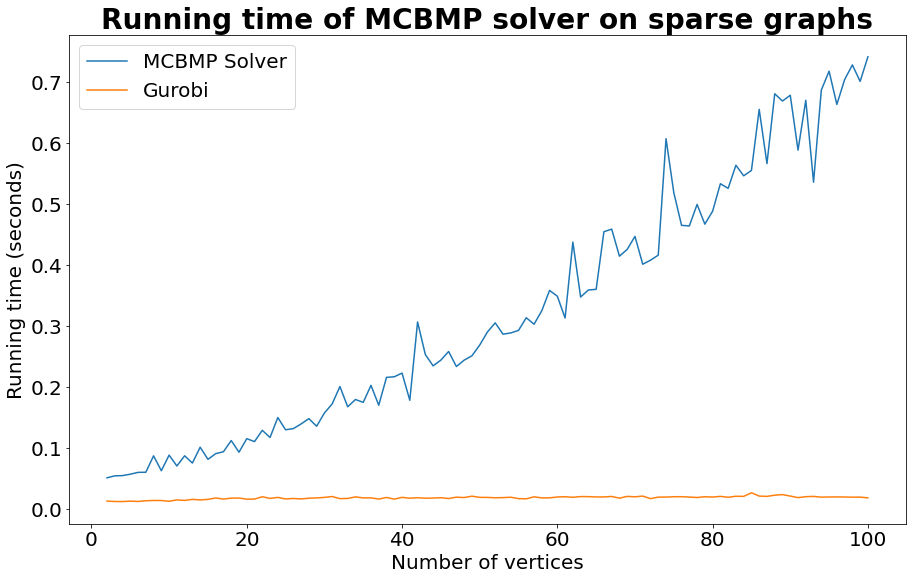

In [43]:
# Plot results
# Source: https://stackoverflow.com/a/37266356/18307616
plt.figure(figsize=(15,9))
lists = sorted(times_brute.items()) # sorted by key, return a list of tuples

x, y = zip(*lists) # unpack a list of pairs into two tuples
plt.plot(x, y)

lists = sorted(times_gurobi.items())

x, y = zip(*lists) # unpack a list of pairs into two tuples
plt.plot(x, y)


plt.legend(['MCBMP Solver', 'Gurobi'], prop={'size':20})
plt.title("Running time of MCBMP solver on sparse graphs", size=28, weight='bold')
plt.xlabel("Number of vertices", size=20)
plt.ylabel("Running time (seconds)", size=20)
plt.tick_params(axis='x', labelsize=20)
plt.tick_params(axis='y', labelsize=20)
plt.show()

In [36]:
'''
Test of budgeted matching polynomial program on dense graphs
Results get saved in dict times_brute_dense and times_gurobi_dense
'''
# Dense Graphs
times_brute_dense = {}
times_gurobi_dense = {}
for n in range(2,101,2):
    print("iterationnumber", n)
    running_time_bruteforce = 0
    running_time_gurobi = 0
    for i in range(5):
        g = generateRandomRestricted(n, 0.8, 10)
        gurobi = restricted_graph_to_gurobi(g, 3*n)
        start = time.time()
        budgetedMatchingPolynomial(g, 3*n)
        end = time.time()
        running_time_bruteforce += end - start
        
        start = time.time()
        gurobi.optimize()
        end = time.time()
        running_time_gurobi += end - start
    times_brute_dense[n] = running_time_bruteforce / 5
    times_gurobi_dense[n] = running_time_gurobi / 5
    


iterationnumber 2
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 3 rows, 1 columns and 3 nonzeros
Model fingerprint: 0xb553d7e4
Variable types: 0 continuous, 1 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 8e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 6e+00]
Found heuristic solution: objective -0.0000000
Presolve removed 3 rows and 1 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.01 seconds
Thread count was 1 (of 12 available processors)

Solution count 1: -0 
No other solutions better than -0

Optimal solution found (tolerance 1.00e-04)
Best objective -0.000000000000e+00, best bound -0.000000000000e+00, gap 0.0000%
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to

Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 7 rows, 13 columns and 39 nonzeros
Model fingerprint: 0x12dd6a98
Variable types: 0 continuous, 13 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+01]
Found heuristic solution: objective 2.0000000
Presolve removed 2 rows and 8 columns
Presolve time: 0.00s
Presolved: 5 rows, 5 columns, 13 nonzeros
Found heuristic solution: objective 2.0000000
Variable types: 0 continuous, 5 integer (5 binary)

Root relaxation: cutoff, 1 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0     cutoff    0         2.00000    2.00000  0.00%     -    0s

Explored 0 nodes (1 simplex iterations) in 0.01 seconds
Thread count was 12 (of 12 available proce

Model fingerprint: 0x0257c01f
Variable types: 0 continuous, 20 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+01]
Found heuristic solution: objective 3.0000000
Presolve removed 0 rows and 4 columns
Presolve time: 0.00s
Presolved: 9 rows, 16 columns, 48 nonzeros
Variable types: 0 continuous, 16 integer (16 binary)

Root relaxation: cutoff, 7 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0     cutoff    0         3.00000    3.00000  0.00%     -    0s

Explored 0 nodes (7 simplex iterations) in 0.01 seconds
Thread count was 12 (of 12 available processors)

Solution count 1: 3 

Optimal solution found (tolerance 1.00e-04)
Best objective 3.000000000000e+00, best bound 3.000000000000e+00, gap 0.0000%
Gurobi Optimizer version 9


Explored 0 nodes (14 simplex iterations) in 0.01 seconds
Thread count was 12 (of 12 available processors)

Solution count 2: 5 3 

Optimal solution found (tolerance 1.00e-04)
Best objective 5.000000000000e+00, best bound 5.000000000000e+00, gap 0.0000%
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 11 rows, 35 columns and 105 nonzeros
Model fingerprint: 0x44b63b13
Variable types: 0 continuous, 35 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 3e+01]
Found heuristic solution: objective 3.0000000
Presolve time: 0.00s
Presolved: 11 rows, 35 columns, 105 nonzeros
Variable types: 0 continuous, 35 integer (35 binary)

Root relaxation: objective 4.400000e+00, 13 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Ex

  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 4e+01]
Found heuristic solution: objective 5.0000000
Presolve time: 0.00s
Presolved: 15 rows, 81 columns, 243 nonzeros
Variable types: 0 continuous, 81 integer (81 binary)

Root relaxation: objective 6.727273e+00, 35 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    6.72727    0    1    5.00000    6.72727  34.5%     -    0s
H    0     0                       6.0000000    6.72727  12.1%     -    0s
     0     0    6.72727    0    1    6.00000    6.72727  12.1%     -    0s

Explored 1 nodes (35 simplex iterations) in 0.01 seconds
Thread count was 12 (of 12 available processors)

Solution count 2: 6 5 

Optimal solution found (tolerance 1.00e-04)
Best objective 6.000000000000e+00, best bound 6.000000000000e+00, gap 0.0000%
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread coun


     0     0    8.00000    0    9    5.00000    8.00000  60.0%     -    0s
H    0     0                       7.0000000    8.00000  14.3%     -    0s
H    0     0                       8.0000000    8.00000  0.00%     -    0s
     0     0    8.00000    0    8    8.00000    8.00000  0.00%     -    0s

Cutting planes:
  Clique: 2

Explored 1 nodes (27 simplex iterations) in 0.02 seconds
Thread count was 12 (of 12 available processors)

Solution count 3: 8 7 5 

Optimal solution found (tolerance 1.00e-04)
Best objective 8.000000000000e+00, best bound 8.000000000000e+00, gap 0.0000%
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 17 rows, 99 columns and 297 nonzeros
Model fingerprint: 0xfa5d41d4
Variable types: 0 continuous, 99 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range   

Best objective 9.000000000000e+00, best bound 9.000000000000e+00, gap 0.0000%
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 19 rows, 124 columns and 372 nonzeros
Model fingerprint: 0x9a594c27
Variable types: 0 continuous, 124 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+01]
Found heuristic solution: objective 5.0000000
Presolve time: 0.00s
Presolved: 19 rows, 124 columns, 372 nonzeros
Variable types: 0 continuous, 124 integer (124 binary)

Root relaxation: objective 9.000000e+00, 28 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    9.00000    0    4    5.00000    9.00000  80.0%     -    0s
H    0     0         

 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

H    0     0                      10.0000000  157.00000  1470%     -    0s
     0     0          -    0        10.00000   10.00000  0.00%     -    0s

Explored 0 nodes (52 simplex iterations) in 0.01 seconds
Thread count was 12 (of 12 available processors)

Solution count 2: 10 6 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.000000000000e+01, best bound 1.000000000000e+01, gap 0.0000%
iterationnumber 22
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 23 rows, 190 columns and 570 nonzeros
Model fingerprint: 0x771ee2d3
Variable types: 0 continuous, 190 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 7e+01]
Found heuristic solution: objective 6.0000000
Presolve time: 0

Found heuristic solution: objective 8.0000000
Presolve time: 0.00s
Presolved: 25 rows, 232 columns, 696 nonzeros
Variable types: 0 continuous, 232 integer (232 binary)

Root relaxation: objective 1.200000e+01, 52 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   12.00000    0    6    8.00000   12.00000  50.0%     -    0s
H    0     0                      11.0000000   12.00000  9.09%     -    0s
H    0     0                      12.0000000   12.00000  0.00%     -    0s
     0     0   12.00000    0    6   12.00000   12.00000  0.00%     -    0s

Explored 1 nodes (82 simplex iterations) in 0.02 seconds
Thread count was 12 (of 12 available processors)

Solution count 3: 12 11 8 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.200000000000e+01, best bound 1.200000000000e+01, gap 0.0000%
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win6

H    0     0                      13.0000000   13.00000  0.00%     -    0s
     0     0   13.00000    0    4   13.00000   13.00000  0.00%     -    0s

Explored 1 nodes (87 simplex iterations) in 0.01 seconds
Thread count was 12 (of 12 available processors)

Solution count 2: 13 9 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.300000000000e+01, best bound 1.300000000000e+01, gap 0.0000%
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 27 rows, 254 columns and 762 nonzeros
Model fingerprint: 0xfd877034
Variable types: 0 continuous, 254 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 8e+01]
Found heuristic solution: objective 8.0000000
Presolve time: 0.00s
Presolved: 27 rows, 254 columns, 762 nonzeros
Variable types: 0 continuous, 254 integer (254

Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 29 rows, 310 columns and 930 nonzeros
Model fingerprint: 0xbba72cc8
Variable types: 0 continuous, 310 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 8e+01]
Found heuristic solution: objective 10.0000000
Presolve time: 0.00s
Presolved: 29 rows, 310 columns, 930 nonzeros
Variable types: 0 continuous, 310 integer (310 binary)

Root relaxation: objective 1.400000e+01, 94 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0      14.0000000   14.00000  0.00%     -    0s

Explored 0 nodes (94 simplex iterations) in 0.01 seconds
Thread count was 12 (of 12 available processors)

Solution count 2: 14 10 

Optimal solution fo

Presolve time: 0.00s
Presolved: 33 rows, 394 columns, 1182 nonzeros
Variable types: 0 continuous, 394 integer (394 binary)

Root relaxation: objective 1.600000e+01, 96 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   16.00000    0    8   12.00000   16.00000  33.3%     -    0s
H    0     0                      16.0000000   16.00000  0.00%     -    0s
     0     0   16.00000    0    8   16.00000   16.00000  0.00%     -    0s

Explored 1 nodes (195 simplex iterations) in 0.02 seconds
Thread count was 12 (of 12 available processors)

Solution count 2: 16 12 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.600000000000e+01, best bound 1.600000000000e+01, gap 0.0000%
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 33 rows, 392 colum


Explored 0 nodes (181 simplex iterations) in 0.02 seconds
Thread count was 12 (of 12 available processors)

Solution count 2: 17 10 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.700000000000e+01, best bound 1.700000000000e+01, gap 0.0000%
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 35 rows, 470 columns and 1410 nonzeros
Model fingerprint: 0x4da8e9a5
Variable types: 0 continuous, 470 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+02]
Found heuristic solution: objective 12.0000000
Presolve time: 0.00s
Presolved: 35 rows, 470 columns, 1410 nonzeros
Variable types: 0 continuous, 470 integer (470 binary)

Root relaxation: objective 1.700000e+01, 98 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |  

Presolved: 37 rows, 502 columns, 1506 nonzeros
Variable types: 0 continuous, 502 integer (502 binary)

Root relaxation: objective 1.800000e+01, 97 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   18.00000    0   15   10.00000   18.00000  80.0%     -    0s
H    0     0                      17.0000000   18.00000  5.88%     -    0s
H    0     0                      18.0000000   18.00000  0.00%     -    0s
     0     0   18.00000    0   15   18.00000   18.00000  0.00%     -    0s

Explored 1 nodes (293 simplex iterations) in 0.02 seconds
Thread count was 12 (of 12 available processors)

Solution count 3: 18 17 10 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.800000000000e+01, best bound 1.800000000000e+01, gap 0.0000%
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 6 physical cores, 12 logical processors, using 

Thread count was 12 (of 12 available processors)

Solution count 2: 19 11 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.900000000000e+01, best bound 1.900000000000e+01, gap 0.0000%
iterationnumber 40
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 41 rows, 653 columns and 1959 nonzeros
Model fingerprint: 0x469856bf
Variable types: 0 continuous, 653 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+02]
Found heuristic solution: objective 13.0000000
Presolve time: 0.00s
Presolved: 41 rows, 653 columns, 1959 nonzeros
Variable types: 0 continuous, 653 integer (653 binary)

Root relaxation: objective 2.000000e+01, 133 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntI

Optimize a model with 43 rows, 672 columns and 2016 nonzeros
Model fingerprint: 0x6fe6c343
Variable types: 0 continuous, 672 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+02]
Found heuristic solution: objective 12.0000000
Presolve time: 0.00s
Presolved: 43 rows, 672 columns, 2016 nonzeros
Variable types: 0 continuous, 672 integer (672 binary)

Root relaxation: objective 2.100000e+01, 137 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

H    0     0                      21.0000000  672.00000  3100%     -    0s
     0     0          -    0        21.00000   21.00000  0.00%     -    0s

Explored 0 nodes (480 simplex iterations) in 0.02 seconds
Thread count was 12 (of 12 available processors)

Solution count 2: 21 12 

Optimal solution f

 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   22.00000    0    4   15.00000   22.00000  46.7%     -    0s
H    0     0                      21.0000000   22.00000  4.76%     -    0s
H    0     0                      22.0000000   22.00000  0.00%     -    0s
     0     0   22.00000    0    4   22.00000   22.00000  0.00%     -    0s

Explored 1 nodes (123 simplex iterations) in 0.02 seconds
Thread count was 12 (of 12 available processors)

Solution count 3: 22 21 15 

Optimal solution found (tolerance 1.00e-04)
Best objective 2.200000000000e+01, best bound 2.200000000000e+01, gap 0.0000%
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 45 rows, 752 columns and 2256 nonzeros
Model fingerprint: 0x1ca16b43
Variable types: 0 continuous, 752 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [1e+00, 

Model fingerprint: 0x5d55b517
Variable types: 0 continuous, 815 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+02]
Found heuristic solution: objective 15.0000000
Presolve time: 0.00s
Presolved: 47 rows, 815 columns, 2445 nonzeros
Variable types: 0 continuous, 815 integer (815 binary)

Root relaxation: objective 2.300000e+01, 155 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   23.00000    0    8   15.00000   23.00000  53.3%     -    0s
H    0     0                      23.0000000   23.00000  0.00%     -    0s
     0     0   23.00000    0    8   23.00000   23.00000  0.00%     -    0s

Explored 1 nodes (155 simplex iterations) in 0.02 seconds
Thread count was 12 (of 12 available processors)

Solution count 2: 23 15 

Opti

     0     0   25.00000    0    9   25.00000   25.00000  0.00%     -    0s

Explored 1 nodes (138 simplex iterations) in 0.02 seconds
Thread count was 12 (of 12 available processors)

Solution count 2: 25 16 

Optimal solution found (tolerance 1.00e-04)
Best objective 2.500000000000e+01, best bound 2.500000000000e+01, gap 0.0000%
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 51 rows, 995 columns and 2985 nonzeros
Model fingerprint: 0x9cb47c6e
Variable types: 0 continuous, 995 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+02]
Found heuristic solution: objective 17.0000000
Presolve time: 0.00s
Presolved: 51 rows, 995 columns, 2985 nonzeros
Variable types: 0 continuous, 995 integer (995 binary)

Root relaxation: objective 2.500000e+01, 123 iterations, 0.0

Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 53 rows, 1068 columns and 3203 nonzeros
Model fingerprint: 0x3ff47c38
Variable types: 0 continuous, 1068 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+02]
Found heuristic solution: objective 16.0000000
Presolve time: 0.00s
Presolved: 53 rows, 1068 columns, 3203 nonzeros
Variable types: 0 continuous, 1068 integer (1068 binary)

Root relaxation: objective 2.600000e+01, 147 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0      26.0000000   26.00000  0.00%     -    0s

Explored 0 nodes (394 simplex iterations) in 0.02 seconds
Thread count was 12 (of 12 avai


Root relaxation: objective 2.700000e+01, 149 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   27.00000    0    8   17.00000   27.00000  58.8%     -    0s
H    0     0                      27.0000000   27.00000  0.00%     -    0s
     0     0   27.00000    0    8   27.00000   27.00000  0.00%     -    0s

Explored 1 nodes (213 simplex iterations) in 0.02 seconds
Thread count was 12 (of 12 available processors)

Solution count 2: 27 17 

Optimal solution found (tolerance 1.00e-04)
Best objective 2.700000000000e+01, best bound 2.700000000000e+01, gap 0.0000%
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 55 rows, 1145 columns and 3435 nonzeros
Model fingerprint: 0x3089c771
Variable types: 0 continuous, 1145 integer (0 binary)
Coefficient stat

Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 59 rows, 1315 columns and 3945 nonzeros
Model fingerprint: 0x84bf0979
Variable types: 0 continuous, 1315 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+02]
Found heuristic solution: objective 16.0000000
Presolve time: 0.01s
Presolved: 59 rows, 1315 columns, 3945 nonzeros
Variable types: 0 continuous, 1315 integer (1315 binary)

Root relaxation: objective 2.900000e+01, 199 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

H    0     0                      29.0000000 1315.00000  4434%     -    0s
     0     0          -    0        29.00000   29.00000  0.00%     -    0s

Explored 0 nod

 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   30.00000    0    6   17.00000   30.00000  76.5%     -    0s
H    0     0                      29.0000000   30.00000  3.45%     -    0s
H    0     0                      30.0000000   30.00000  0.00%     -    0s
     0     0   30.00000    0    6   30.00000   30.00000  0.00%     -    0s

Explored 1 nodes (131 simplex iterations) in 0.02 seconds
Thread count was 12 (of 12 available processors)

Solution count 3: 30 29 17 

Optimal solution found (tolerance 1.00e-04)
Best objective 3.000000000000e+01, best bound 3.000000000000e+01, gap 0.0000%
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 61 rows, 1418 columns and 4254 nonzeros
Model fingerprint: 0x96325937
Variable types: 0 continuous, 1418 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [1e+00


Explored 1 nodes (187 simplex iterations) in 0.02 seconds
Thread count was 12 (of 12 available processors)

Solution count 3: 31 30 19 

Optimal solution found (tolerance 1.00e-04)
Best objective 3.100000000000e+01, best bound 3.100000000000e+01, gap 0.0000%
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 63 rows, 1513 columns and 4539 nonzeros
Model fingerprint: 0xf862b1a7
Variable types: 0 continuous, 1513 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+02]
Found heuristic solution: objective 18.0000000
Presolve time: 0.01s
Presolved: 63 rows, 1513 columns, 4539 nonzeros
Variable types: 0 continuous, 1513 integer (1513 binary)

Root relaxation: objective 3.100000e+01, 162 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds

Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 65 rows, 1642 columns and 4926 nonzeros
Model fingerprint: 0xfbff7b35
Variable types: 0 continuous, 1642 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+02]
Found heuristic solution: objective 20.0000000
Presolve time: 0.01s
Presolved: 65 rows, 1642 columns, 4926 nonzeros
Variable types: 0 continuous, 1642 integer (1642 binary)

Root relaxation: objective 3.200000e+01, 160 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0      32.0000000   32.00000  0.00%     -    0s

Explored 0 nodes (160 simplex iterations) in 0.02 seconds
Thread count was 12 (of 12 available processors)

Solution count 2: 32 20 

Optimal so


Root relaxation: objective 3.400000e+01, 183 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0      34.0000000   34.00000  0.00%     -    0s

Explored 0 nodes (183 simplex iterations) in 0.02 seconds
Thread count was 12 (of 12 available processors)

Solution count 2: 34 20 

Optimal solution found (tolerance 1.00e-04)
Best objective 3.400000000000e+01, best bound 3.400000000000e+01, gap 0.0000%
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 69 rows, 1826 columns and 5478 nonzeros
Model fingerprint: 0x47ddef42
Variable types: 0 continuous, 1826 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+02]
Found 

Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 71 rows, 1910 columns and 5730 nonzeros
Model fingerprint: 0xdc8c4ce0
Variable types: 0 continuous, 1910 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+02]
Found heuristic solution: objective 20.0000000
Presolve time: 0.01s
Presolved: 71 rows, 1910 columns, 5730 nonzeros
Variable types: 0 continuous, 1910 integer (1910 binary)

Root relaxation: objective 3.500000e+01, 177 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   35.00000    0    6   20.00000   35.00000  75.0%     -    0s
H    0     0                      34.0000000   35.00000  2.94%     -    0s
H    0     0   

Coefficient statistics:
  Matrix range     [1e+00, 3e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+02]
Found heuristic solution: objective 22.0000000
Presolve time: 0.01s
Presolved: 73 rows, 2066 columns, 6198 nonzeros
Variable types: 0 continuous, 2066 integer (2066 binary)

Root relaxation: objective 3.600000e+01, 213 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   36.00000    0    4   22.00000   36.00000  63.6%     -    0s
H    0     0                      35.0000000   36.00000  2.86%     -    0s
H    0     0                      36.0000000   36.00000  0.00%     -    0s
     0     0   36.00000    0    4   36.00000   36.00000  0.00%     -    0s

Explored 1 nodes (1254 simplex iterations) in 0.03 seconds
Thread count was 12 (of 12 available processors)

Solution count 3: 36 35 22 

Optim

 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

H    0     0                      37.0000000 2161.00000  5741%     -    0s
     0     0          -    0        37.00000   37.00000  0.00%     -    0s

Explored 0 nodes (1609 simplex iterations) in 0.03 seconds
Thread count was 12 (of 12 available processors)

Solution count 2: 37 23 

Optimal solution found (tolerance 1.00e-04)
Best objective 3.700000000000e+01, best bound 3.700000000000e+01, gap 0.0000%
iterationnumber 76
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 77 rows, 2216 columns and 6648 nonzeros
Model fingerprint: 0x2d7a5717
Variable types: 0 continuous, 2216 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+02]
Found heuristic solution: objective 28.0000000
Presolve 

Model fingerprint: 0x77f85ceb
Variable types: 0 continuous, 2430 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+02]
Found heuristic solution: objective 23.0000000
Presolve time: 0.01s
Presolved: 79 rows, 2430 columns, 7290 nonzeros
Variable types: 0 continuous, 2430 integer (2430 binary)

Root relaxation: objective 3.900000e+01, 210 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   39.00000    0    7   23.00000   39.00000  69.6%     -    0s
H    0     0                      39.0000000   39.00000  0.00%     -    0s
     0     0   39.00000    0    7   39.00000   39.00000  0.00%     -    0s

Explored 1 nodes (925 simplex iterations) in 0.03 seconds
Thread count was 12 (of 12 available processors)

Solution count 2: 39 23 




H    0     0                      40.0000000 2535.00000  6238%     -    0s
     0     0          -    0        40.00000   40.00000  0.00%     -    0s

Explored 0 nodes (718 simplex iterations) in 0.03 seconds
Thread count was 12 (of 12 available processors)

Solution count 2: 40 24 

Optimal solution found (tolerance 1.00e-04)
Best objective 4.000000000000e+01, best bound 4.000000000000e+01, gap 0.0000%
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 81 rows, 2537 columns and 7611 nonzeros
Model fingerprint: 0xf1dae649
Variable types: 0 continuous, 2537 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+02]
Found heuristic solution: objective 25.0000000
Presolve time: 0.01s
Presolved: 81 rows, 2537 columns, 7611 nonzeros
Variable types: 0 continuous, 2537 in

Model fingerprint: 0x23a158e8
Variable types: 0 continuous, 2645 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+02]
Found heuristic solution: objective 22.0000000
Presolve time: 0.01s
Presolved: 83 rows, 2645 columns, 7935 nonzeros
Variable types: 0 continuous, 2645 integer (2645 binary)

Root relaxation: objective 4.100000e+01, 241 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

H    0     0                      41.0000000 2645.00000  6351%     -    0s
     0     0          -    0        41.00000   41.00000  0.00%     -    0s

Explored 0 nodes (695 simplex iterations) in 0.03 seconds
Thread count was 12 (of 12 available processors)

Solution count 2: 41 22 

Optimal solution found (tolerance 1.00e-04)
Best objective 4.100000000000e+

 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   43.00000    0    6   26.00000   43.00000  65.4%     -    0s
H    0     0                      42.0000000   43.00000  2.38%     -    0s
H    0     0                      43.0000000   43.00000  0.00%     -    0s
     0     0   43.00000    0    6   43.00000   43.00000  0.00%     -    0s

Explored 1 nodes (898 simplex iterations) in 0.04 seconds
Thread count was 12 (of 12 available processors)

Solution count 3: 43 42 26 

Optimal solution found (tolerance 1.00e-04)
Best objective 4.300000000000e+01, best bound 4.300000000000e+01, gap 0.0000%
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 87 rows, 2946 columns and 8838 nonzeros
Model fingerprint: 0x8b754794
Variable types: 0 continuous, 2946 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [1e+00


Optimal solution found (tolerance 1.00e-04)
Best objective 4.400000000000e+01, best bound 4.400000000000e+01, gap 0.0000%
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 89 rows, 3041 columns and 9123 nonzeros
Model fingerprint: 0xa248b226
Variable types: 0 continuous, 3041 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 3e+02]
Found heuristic solution: objective 30.0000000
Presolve time: 0.01s
Presolved: 89 rows, 3041 columns, 9123 nonzeros
Variable types: 0 continuous, 3041 integer (3041 binary)

Root relaxation: objective 4.400000e+01, 191 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0      44.00000

Variable types: 0 continuous, 3221 integer (3221 binary)

Root relaxation: objective 4.500000e+01, 247 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

H    0     0                      45.0000000 3221.00000  7058%     -    0s
     0     0          -    0        45.00000   45.00000  0.00%     -    0s

Explored 0 nodes (1159 simplex iterations) in 0.04 seconds
Thread count was 12 (of 12 available processors)

Solution count 2: 45 29 

Optimal solution found (tolerance 1.00e-04)
Best objective 4.500000000000e+01, best bound 4.500000000000e+01, gap 0.0000%
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 91 rows, 3181 columns and 9543 nonzeros
Model fingerprint: 0x00b36fae
Variable types: 0 continuous, 3181 integer (0 binary)
Coefficient statistics:
  Matrix 

Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 95 rows, 3535 columns and 10605 nonzeros
Model fingerprint: 0xd46cd711
Variable types: 0 continuous, 3535 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 3e+02]
Found heuristic solution: objective 27.0000000
Presolve time: 0.01s
Presolved: 95 rows, 3535 columns, 10605 nonzeros
Variable types: 0 continuous, 3535 integer (3535 binary)

Root relaxation: objective 4.700000e+01, 291 iterations, 0.01 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0      47.0000000   47.00000  0.00%     -    0s

Explored 0 nodes (1501 simplex iterations) in 0.04 seconds
Thread count was 12 (of 12 available processors)

Solution count 2: 47 27 

Optimal


    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

H    0     0                      48.0000000 3582.00000  7363%     -    0s
     0     0          -    0        48.00000   48.00000  0.00%     -    0s

Explored 0 nodes (883 simplex iterations) in 0.04 seconds
Thread count was 12 (of 12 available processors)

Solution count 2: 48 29 

Optimal solution found (tolerance 1.00e-04)
Best objective 4.800000000000e+01, best bound 4.800000000000e+01, gap 0.0000%
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 97 rows, 3648 columns and 10944 nonzeros
Model fingerprint: 0x081482f2
Variable types: 0 continuous, 3648 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 3e+02]
F

Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 99 rows, 3819 columns and 11457 nonzeros
Model fingerprint: 0x235164ed
Variable types: 0 continuous, 3819 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 3e+02]
Found heuristic solution: objective 29.0000000
Presolve time: 0.01s
Presolved: 99 rows, 3819 columns, 11457 nonzeros
Variable types: 0 continuous, 3819 integer (3819 binary)

Root relaxation: objective 4.900000e+01, 253 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0      49.0000000   49.00000  0.00%     -    0s

Explored 0 nodes (253 simplex iterations) in 0.03 seconds
Thread count was 12 (of 12 av

Variable types: 0 continuous, 3953 integer (3953 binary)

Root relaxation: objective 5.000000e+01, 271 iterations, 0.01 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0      50.0000000   50.00000  0.00%     -    0s

Explored 0 nodes (1356 simplex iterations) in 0.05 seconds
Thread count was 12 (of 12 available processors)

Solution count 2: 50 29 

Optimal solution found (tolerance 1.00e-04)
Best objective 5.000000000000e+01, best bound 5.000000000000e+01, gap 0.0000%


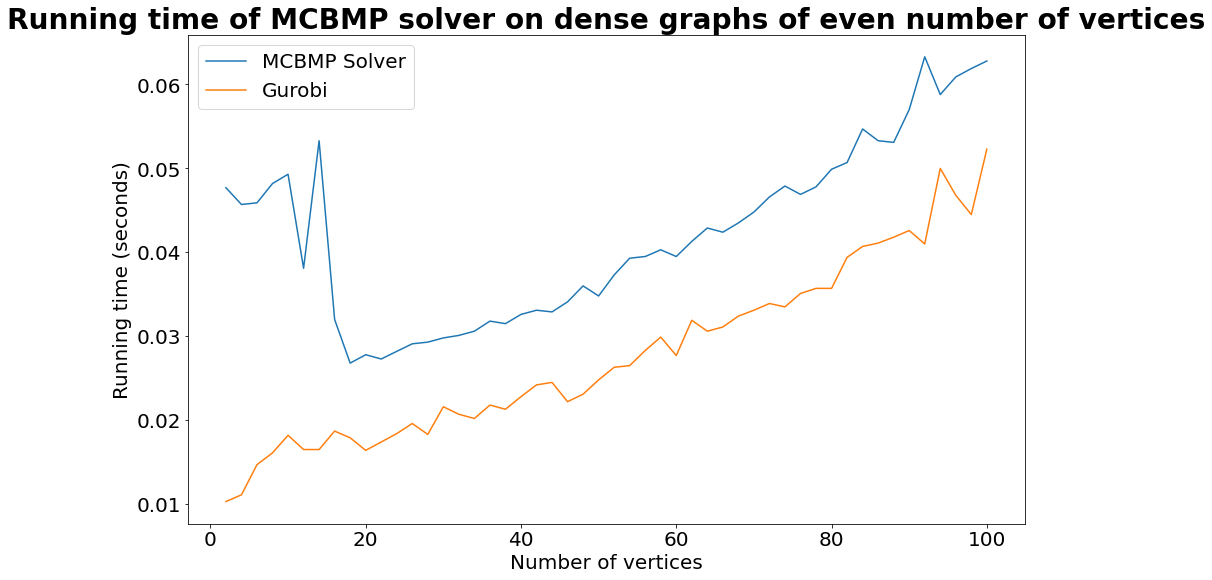

In [37]:
# Plot results
# Source: https://stackoverflow.com/a/37266356/18307616
plt.figure(figsize=(15,9))
lists = sorted(times_brute_dense.items()) # sorted by key, return a list of tuples

x, y = zip(*lists) # unpack a list of pairs into two tuples

plt.plot(x, y)

lists = sorted(times_gurobi_dense.items())

x, y = zip(*lists) # unpack a list of pairs into two tuples

plt.plot(x, y)


plt.legend(['MCBMP Solver', 'Gurobi'], prop={'size':20})
plt.title("Running time of MCBMP solver on dense graphs of even number of vertices", size=28, weight='bold')
plt.xlabel("Number of vertices", size=20)
plt.ylabel("Running time (seconds)", size=20)
plt.tick_params(axis='x', labelsize=20)
plt.tick_params(axis='y', labelsize=20)
plt.show()